# Telecom Churn Case Study - Kaggle

#### Submission By: L Rohan and Rohit Raju Vatsavaya

## Importing Libraries

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.feature_selection import RFE
from imblearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split, GridSearchCV
from imblearn.over_sampling import SMOTE
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score
from sklearn.decomposition import PCA

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [6]:
# Set environment settings
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_colwidth', 1000)

In [7]:
# Reading the dataset

train = pd.read_csv("train.csv")
unseen = pd.read_csv("test.csv")
sample = pd.read_csv("sample.csv")
data_dict = pd.read_csv("data_dictionary.csv")

print("Dimension of the training dataset is", train.shape)
print("Dimension of the unseen dataset is", unseen.shape)
print("Dimension of the sample dataset is", sample.shape)
print("Dimension of the data dictionary is", data_dict.shape)

Dimension of the training dataset is (69999, 172)
Dimension of the unseen dataset is (30000, 171)
Dimension of the sample dataset is (30000, 2)
Dimension of the data dictionary is (36, 2)


In [8]:
# Inspecting the data dictionary
data_dict

Acronyms  \
0     CIRCLE_ID   
1           LOC   
2           STD   
3            IC   
4            OG   
5           T2T   
6       T2M       
7       T2O       
8       T2F       
9       T2C       
10     ARPU       
11      MOU       
12      AON       
13     ONNET      
14   OFFNET       
15         ROAM   
16       SPL      
17      ISD       
18     RECH       
19      NUM       
20      AMT       
21      MAX       
22     DATA       
23       3G       
24       AV       
25      VOL       
26       2G       
27      PCK       
28    NIGHT       
29  MONTHLY       
30    SACHET      
31      *.6       
32      *.7       
33      *.8       
34      FB_USER   
35      VBC       

                                                                          Description  
0                                Telecom circle area to which the customer belongs to  
1                                             Local calls  within same telecom circle  
2                                               STD calls  outside the calling circle  
3                                                                      Incoming calls  
4                                                                      Outgoing calls  
5                            Operator T to T ie within same operator mobile to mobile  
6                                                 Operator T to other operator mobile  
7                                             Operator T to other operator fixed line  
8                                                      Operator T to fixed lines of T  
9                                                   Operator T to its own call center  
10                                                           Average revenue per user  
11                                                      Minutes of usage  voice calls  
12        Age on network  number of days the customer is using the operator T network  
13                                 All kind of calls within the same operator network  
14                                   All kind of calls outside the operator T network  
15                         Indicates that customer is in roaming zone during the call  
16                                                                      Special calls  
17                                                                          ISD calls  
18                                                                           Recharge  
19                                                                             Number  
20                                                           Amount in local currency  
21                                                                            Maximum  
22                                                                    Mobile internet  
23                                                                          G network  
24                                                                            Average  
25                                                 Mobile internet usage volume in MB  
26                                                                          G network  
27                                              Prepaid service schemes called  PACKS  
28                                     Scheme to use during specific night hours only  
29                                Service schemes with validity equivalent to a month  
30                                 Service schemes with validity smaller than a month  
31                                                          KPI for the month of June  
32                                                          KPI for the month of July  
33                                                        KPI for the month of August  
34   Service scheme to avail services of Facebook and similar social networking sites  
35  Volume based cost  when no specific scheme is not purchased and paid as per usage

In [9]:
# Inspecting the train dataset
train.info(verbose=1)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 69999 entries, 0 to 69998
Data columns (total 172 columns):
 #    Column                    Dtype  
---   ------                    -----  
 0    id                        int64  
 1    circle_id                 int64  
 2    loc_og_t2o_mou            float64
 3    std_og_t2o_mou            float64
 4    loc_ic_t2o_mou            float64
 5    last_date_of_month_6      object 
 6    last_date_of_month_7      object 
 7    last_date_of_month_8      object 
 8    arpu_6                    float64
 9    arpu_7                    float64
 10   arpu_8                    float64
 11   onnet_mou_6               float64
 12   onnet_mou_7               float64
 13   onnet_mou_8               float64
 14   offnet_mou_6              float64
 15   offnet_mou_7              float64
 16   offnet_mou_8              float64
 17   roam_ic_mou_6             float64
 18   roam_ic_mou_7             float64
 19   roam_ic_mou_8             float64
 20   roam

In [10]:
# Statistics summary of the train dataset
train.describe().T

count          mean           std       min         25%  \
id                  69999.0  34999.000000  20207.115084     0.000  17499.5000   
circle_id           69999.0    109.000000      0.000000   109.000    109.0000   
loc_og_t2o_mou      69297.0      0.000000      0.000000     0.000      0.0000   
std_og_t2o_mou      69297.0      0.000000      0.000000     0.000      0.0000   
loc_ic_t2o_mou      69297.0      0.000000      0.000000     0.000      0.0000   
arpu_6              69999.0    283.134365    334.213918 -2258.709     93.5810   
arpu_7              69999.0    278.185912    344.366927 -1289.715     86.7140   
arpu_8              69999.0    278.858826    351.924315  -945.808     84.0950   
onnet_mou_6         67231.0    133.153275    299.963093     0.000      7.4100   
onnet_mou_7         67312.0    133.894438    311.277193     0.000      6.6750   
onnet_mou_8         66296.0    132.978257    311.896596     0.000      6.4100   
offnet_mou_6        67231.0    198.874771    316.818355     0.000     34.8600   
offnet_mou_7        67312.0    197.153383    322.482226     0.000     32.2400   
offnet_mou_8        66296.0    196.543577    324.089234     0.000     31.5750   
roam_ic_mou_6       67231.0      9.765435     57.374429     0.000      0.0000   
roam_ic_mou_7       67312.0      7.014568     55.960985     0.000      0.0000   
roam_ic_mou_8       66296.0      7.004892     53.408135     0.000      0.0000   
roam_og_mou_6       67231.0     14.186457     73.469261     0.000      0.0000   
roam_og_mou_7       67312.0      9.842191     58.511894     0.000      0.0000   
roam_og_mou_8       66296.0      9.771783     64.618388     0.000      0.0000   
loc_og_t2t_mou_6    67231.0     46.904854    150.971758     0.000      1.6600   
loc_og_t2t_mou_7    67312.0     46.166503    154.739002     0.000      1.6500   
loc_og_t2t_mou_8    66296.0     45.686109    153.716880     0.000      1.6100   
loc_og_t2m_mou_6    67231.0     93.238231    162.046699     0.000      9.9200   
loc_og_t2m_mou_7    67312.0     90.799240    153.852597     0.000     10.0900   
loc_og_t2m_mou_8    66296.0     91.121447    152.997805     0.000      9.8300   
loc_og_t2f_mou_6    67231.0      3.743179     13.319542     0.000      0.0000   
loc_og_t2f_mou_7    67312.0      3.777031     13.568110     0.000      0.0000   
loc_og_t2f_mou_8    66296.0      3.661652     13.009193     0.000      0.0000   
loc_og_t2c_mou_6    67231.0      1.126025      5.741811     0.000      0.0000   
loc_og_t2c_mou_7    67312.0      1.361052      7.914113     0.000      0.0000   
loc_og_t2c_mou_8    66296.0      1.420840      6.542202     0.000      0.0000   
loc_og_mou_6        67231.0    143.893585    252.034597     0.000     17.2350   
loc_og_mou_7        67312.0    140.750120    246.313148     0.000     17.5900   
loc_og_mou_8        66296.0    140.476486    245.342359     0.000     17.2375   
std_og_t2t_mou_6    67231.0     80.619382    255.098355     0.000      0.0000   
std_og_t2t_mou_7    67312.0     83.775851    266.693254     0.000      0.0000   
std_og_t2t_mou_8    66296.0     83.471486    267.021929     0.000      0.0000   
std_og_t2m_mou_6    67231.0     88.152110    255.771554     0.000      0.0000   
std_og_t2m_mou_7    67312.0     91.538615    267.532089     0.000      0.0000   
std_og_t2m_mou_8    66296.0     90.586999    270.032002     0.000      0.0000   
std_og_t2f_mou_6    67231.0      1.126377      8.136645     0.000      0.0000   
std_og_t2f_mou_7    67312.0      1.084062      8.325206     0.000      0.0000   
std_og_t2f_mou_8    66296.0      1.057739      7.696853     0.000      0.0000   
std_og_t2c_mou_6    67231.0      0.000000      0.000000     0.000      0.0000   
std_og_t2c_mou_7    67312.0      0.000000      0.000000     0.000      0.0000   
std_og_t2c_mou_8    66296.0      0.000000      0.000000     0.000      0.0000   
std_og_mou_6        67231.0    169.900601    392.046600     0.000      0.0000   
std_og_mou_7        67312.0    176.401217    409.2995

In [11]:
# Creating the copy of the original training set
telecom_df = train.copy()

In [12]:
# Creating the copy of the original test set
telecom_test_df = unseen.copy()

## Data Cleaning and Preparation

###  Checking the columns with single unique value

In [13]:
cols_with_single_value = []
for col in train.columns:
    if train[col].nunique() == 1:
        cols_with_single_value.append(col)

print(cols_with_single_value)

['circle_id', 'loc_og_t2o_mou', 'std_og_t2o_mou', 'loc_ic_t2o_mou', 'last_date_of_month_6', 'last_date_of_month_7', 'last_date_of_month_8', 'std_og_t2c_mou_6', 'std_og_t2c_mou_7', 'std_og_t2c_mou_8', 'std_ic_t2o_mou_6', 'std_ic_t2o_mou_7', 'std_ic_t2o_mou_8']


In [14]:
# Inspecting circle id
for col in cols_with_single_value:
    print(col)
    print(train[col].value_counts(dropna=False))
    print("--------------------------------------")

circle_id
circle_id
109    69999
Name: count, dtype: int64
--------------------------------------
loc_og_t2o_mou
loc_og_t2o_mou
0.0    69297
NaN      702
Name: count, dtype: int64
--------------------------------------
std_og_t2o_mou
std_og_t2o_mou
0.0    69297
NaN      702
Name: count, dtype: int64
--------------------------------------
loc_ic_t2o_mou
loc_ic_t2o_mou
0.0    69297
NaN      702
Name: count, dtype: int64
--------------------------------------
last_date_of_month_6
last_date_of_month_6
6/30/2014    69999
Name: count, dtype: int64
--------------------------------------
last_date_of_month_7
last_date_of_month_7
7/31/2014    69600
NaN            399
Name: count, dtype: int64
--------------------------------------
last_date_of_month_8
last_date_of_month_8
8/31/2014    69266
NaN            733
Name: count, dtype: int64
--------------------------------------
std_og_t2c_mou_6
std_og_t2c_mou_6
0.0    67231
NaN     2768
Name: count, dtype: int64
-------------------------------------

In [15]:
# Based on the dataset, we remove these columns from the training set
train.drop(cols_with_single_value, axis=1, inplace=True)

# Based on the dataset, we remove these columns from the test set
unseen.drop(cols_with_single_value, axis=1, inplace=True)

In [16]:
# Remove the id column since it is unique for every row from the training set
train.drop('id', axis=1, inplace=True)

In [17]:
# Generating a list of column names based on their corresponding types

date_cols = ['date_of_last_rech_6',
            'date_of_last_rech_7',
            'date_of_last_rech_8',
            'date_of_last_rech_data_6',
            'date_of_last_rech_data_7',
            'date_of_last_rech_data_8',
            ]

cat_cols = ['night_pck_user_6',
            'night_pck_user_7',
            'night_pck_user_8',
            'fb_user_6',
            'fb_user_7',
            'fb_user_8',
           ]

numerical_cols = [col for col in train.columns if col not in date_cols + cat_cols]

In [18]:
# Dropping date columns as they are not useful for our analysis from the training set
train.drop(columns=date_cols, axis=1, inplace=True)

# Dropping date columns as they are not useful for our analysis from the test set
unseen.drop(columns=date_cols, axis=1, inplace=True)

In [19]:
### Check for columns with more than 70% missing values in the training dataset
mv_train_set = round(100*(train.isna().sum(axis=0)/train.shape[0]), 2)
mv_train_set[mv_train_set > 70].sort_values(ascending=False)

total_rech_data_6     74.90
arpu_3g_6             74.90
max_rech_data_6       74.90
fb_user_6             74.90
count_rech_2g_6       74.90
night_pck_user_6      74.90
count_rech_3g_6       74.90
arpu_2g_6             74.90
av_rech_amt_data_6    74.90
fb_user_7             74.48
night_pck_user_7      74.48
arpu_2g_7             74.48
arpu_3g_7             74.48
av_rech_amt_data_7    74.48
total_rech_data_7     74.48
count_rech_3g_7       74.48
count_rech_2g_7       74.48
max_rech_data_7       74.48
av_rech_amt_data_8    73.69
count_rech_3g_8       73.69
arpu_3g_8             73.69
count_rech_2g_8       73.69
arpu_2g_8             73.69
max_rech_data_8       73.69
night_pck_user_8      73.69
total_rech_data_8     73.69
fb_user_8             73.69
dtype: float64

There are numerous variables with consistent percentages of missing data, suggesting a pattern of meaningful absence. Our strategy involves grouping similar data for analysis:

1. Grouping and treating missing values for 'recharge-related' data.
2. Grouping and treating missing values for 'ARPU' data.
3. Conducting missing value treatment on categorical columns.

#### Recharge Columns

In [20]:
# Columns with recharge information 
recharge_cols = train.columns[train.columns.str.contains('_rech_')]
print(recharge_cols)

Index(['total_rech_num_6', 'total_rech_num_7', 'total_rech_num_8',
       'total_rech_amt_6', 'total_rech_amt_7', 'total_rech_amt_8',
       'max_rech_amt_6', 'max_rech_amt_7', 'max_rech_amt_8',
       'total_rech_data_6', 'total_rech_data_7', 'total_rech_data_8',
       'max_rech_data_6', 'max_rech_data_7', 'max_rech_data_8',
       'count_rech_2g_6', 'count_rech_2g_7', 'count_rech_2g_8',
       'count_rech_3g_6', 'count_rech_3g_7', 'count_rech_3g_8',
       'av_rech_amt_data_6', 'av_rech_amt_data_7', 'av_rech_amt_data_8'],
      dtype='object')


In [21]:
# Replacing NaN values in recharge related columns with 0 in the training set
train[recharge_cols] = train[recharge_cols].fillna(0)
print(train[recharge_cols].isnull().sum()*100/train.shape[1])

total_rech_num_6      0.0
total_rech_num_7      0.0
total_rech_num_8      0.0
total_rech_amt_6      0.0
total_rech_amt_7      0.0
total_rech_amt_8      0.0
max_rech_amt_6        0.0
max_rech_amt_7        0.0
max_rech_amt_8        0.0
total_rech_data_6     0.0
total_rech_data_7     0.0
total_rech_data_8     0.0
max_rech_data_6       0.0
max_rech_data_7       0.0
max_rech_data_8       0.0
count_rech_2g_6       0.0
count_rech_2g_7       0.0
count_rech_2g_8       0.0
count_rech_3g_6       0.0
count_rech_3g_7       0.0
count_rech_3g_8       0.0
av_rech_amt_data_6    0.0
av_rech_amt_data_7    0.0
av_rech_amt_data_8    0.0
dtype: float64


In [22]:
# Replacing NaN values in recharge related columns with 0 in the test set
unseen[recharge_cols] = unseen[recharge_cols].fillna(0)
print(unseen[recharge_cols].isnull().sum()*100/unseen.shape[1])

total_rech_num_6      0.0
total_rech_num_7      0.0
total_rech_num_8      0.0
total_rech_amt_6      0.0
total_rech_amt_7      0.0
total_rech_amt_8      0.0
max_rech_amt_6        0.0
max_rech_amt_7        0.0
max_rech_amt_8        0.0
total_rech_data_6     0.0
total_rech_data_7     0.0
total_rech_data_8     0.0
max_rech_data_6       0.0
max_rech_data_7       0.0
max_rech_data_8       0.0
count_rech_2g_6       0.0
count_rech_2g_7       0.0
count_rech_2g_8       0.0
count_rech_3g_6       0.0
count_rech_3g_7       0.0
count_rech_3g_8       0.0
av_rech_amt_data_6    0.0
av_rech_amt_data_7    0.0
av_rech_amt_data_8    0.0
dtype: float64


#### ARPU Columns

In [23]:
# Columns with 'arpu' information 
arpu_cols = train.columns[train.columns.str.contains('arpu_')]
print(arpu_cols)

Index(['arpu_6', 'arpu_7', 'arpu_8', 'arpu_3g_6', 'arpu_3g_7', 'arpu_3g_8',
       'arpu_2g_6', 'arpu_2g_7', 'arpu_2g_8'],
      dtype='object')


In [24]:
# Replacing NaN values in ARPU related columns with 0 in the training set
train[arpu_cols] = train[arpu_cols].fillna(0)
print(train[arpu_cols].isnull().sum()*100/train.shape[1])

arpu_6       0.0
arpu_7       0.0
arpu_8       0.0
arpu_3g_6    0.0
arpu_3g_7    0.0
arpu_3g_8    0.0
arpu_2g_6    0.0
arpu_2g_7    0.0
arpu_2g_8    0.0
dtype: float64


In [25]:
# Replacing NaN values in ARPU related columns with 0 in the test set
unseen[arpu_cols] = unseen[arpu_cols].fillna(0)
print(unseen[arpu_cols].isnull().sum()*100/unseen.shape[1])

arpu_6       0.0
arpu_7       0.0
arpu_8       0.0
arpu_3g_6    0.0
arpu_3g_7    0.0
arpu_3g_8    0.0
arpu_2g_6    0.0
arpu_2g_7    0.0
arpu_2g_8    0.0
dtype: float64


#### Categorical Columns

In [26]:
# Inspecting categorical columns
train[cat_cols].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 69999 entries, 0 to 69998
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   night_pck_user_6  17568 non-null  float64
 1   night_pck_user_7  17865 non-null  float64
 2   night_pck_user_8  18417 non-null  float64
 3   fb_user_6         17568 non-null  float64
 4   fb_user_7         17865 non-null  float64
 5   fb_user_8         18417 non-null  float64
dtypes: float64(6)
memory usage: 3.2 MB


##### Imputing missing values in Categorical Columns

##### Imputing missing categorical values with a value of -1 facilitates the preservation and identification of missing data while ensuring compatibility with analysis algorithms and maintaining consistency in data encoding.

In [27]:
# Replacing NaN values in categorical related columns with -1 in the training set.
# We noticed that the columns listed in `cat_cols` are of the `float64` data type.
# We'll need to convert them to the `category` data type.
train[cat_cols] = train[cat_cols].fillna(-1).astype('category')
print(train[cat_cols].isnull().sum()*100/train.shape[1])

night_pck_user_6    0.0
night_pck_user_7    0.0
night_pck_user_8    0.0
fb_user_6           0.0
fb_user_7           0.0
fb_user_8           0.0
dtype: float64


In [28]:
# Verifying the change in dtype on the train set
train[cat_cols].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 69999 entries, 0 to 69998
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype   
---  ------            --------------  -----   
 0   night_pck_user_6  69999 non-null  category
 1   night_pck_user_7  69999 non-null  category
 2   night_pck_user_8  69999 non-null  category
 3   fb_user_6         69999 non-null  category
 4   fb_user_7         69999 non-null  category
 5   fb_user_8         69999 non-null  category
dtypes: category(6)
memory usage: 411.0 KB


In [29]:
# Replacing NaN values in categorical related columns with -1 in the test set.
# We noticed that the columns listed in `cat_cols` are of the `float64` data type.
# We'll need to convert them to the `category` data type.
unseen[cat_cols] = unseen[cat_cols].fillna(-1).astype('category')
print(unseen[cat_cols].isnull().sum()*100/unseen.shape[1])

night_pck_user_6    0.0
night_pck_user_7    0.0
night_pck_user_8    0.0
fb_user_6           0.0
fb_user_7           0.0
fb_user_8           0.0
dtype: float64


In [30]:
# Verifying the change in dtype on the test set
unseen[cat_cols].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype   
---  ------            --------------  -----   
 0   night_pck_user_6  30000 non-null  category
 1   night_pck_user_7  30000 non-null  category
 2   night_pck_user_8  30000 non-null  category
 3   fb_user_6         30000 non-null  category
 4   fb_user_7         30000 non-null  category
 5   fb_user_8         30000 non-null  category
dtypes: category(6)
memory usage: 176.7 KB


In [31]:
# Checking for the columns which have missing values present
mv_train_set[(mv_train_set > 0) & (mv_train_set <= 70)].sort_values(ascending=False)

ic_others_8         5.29
loc_og_t2m_mou_8    5.29
std_og_mou_8        5.29
spl_og_mou_8        5.29
std_og_t2f_mou_8    5.29
og_others_8         5.29
std_og_t2m_mou_8    5.29
loc_ic_t2t_mou_8    5.29
std_og_t2t_mou_8    5.29
loc_ic_t2m_mou_8    5.29
loc_og_mou_8        5.29
loc_ic_t2f_mou_8    5.29
loc_og_t2c_mou_8    5.29
loc_ic_mou_8        5.29
isd_og_mou_8        5.29
std_ic_t2t_mou_8    5.29
loc_og_t2f_mou_8    5.29
std_ic_t2m_mou_8    5.29
spl_ic_mou_8        5.29
onnet_mou_8         5.29
loc_og_t2t_mou_8    5.29
std_ic_t2f_mou_8    5.29
isd_ic_mou_8        5.29
roam_og_mou_8       5.29
std_ic_mou_8        5.29
offnet_mou_8        5.29
roam_ic_mou_8       5.29
ic_others_6         3.95
og_others_6         3.95
loc_ic_t2t_mou_6    3.95
isd_ic_mou_6        3.95
spl_ic_mou_6        3.95
loc_ic_t2m_mou_6    3.95
std_ic_t2m_mou_6    3.95
loc_ic_t2f_mou_6    3.95
loc_ic_mou_6        3.95
std_ic_mou_6        3.95
std_ic_t2t_mou_6    3.95
std_ic_t2f_mou_6    3.95
spl_og_mou_6        3.95


In [32]:
# Creating a list containing these columns to be processed later for imputation using the KNN technique.
missing_values_list = mv_train_set[(mv_train_set > 0) & (mv_train_set <= 70)].index
print(missing_values_list)

Index(['onnet_mou_6', 'onnet_mou_7', 'onnet_mou_8', 'offnet_mou_6',
       'offnet_mou_7', 'offnet_mou_8', 'roam_ic_mou_6', 'roam_ic_mou_7',
       'roam_ic_mou_8', 'roam_og_mou_6', 'roam_og_mou_7', 'roam_og_mou_8',
       'loc_og_t2t_mou_6', 'loc_og_t2t_mou_7', 'loc_og_t2t_mou_8',
       'loc_og_t2m_mou_6', 'loc_og_t2m_mou_7', 'loc_og_t2m_mou_8',
       'loc_og_t2f_mou_6', 'loc_og_t2f_mou_7', 'loc_og_t2f_mou_8',
       'loc_og_t2c_mou_6', 'loc_og_t2c_mou_7', 'loc_og_t2c_mou_8',
       'loc_og_mou_6', 'loc_og_mou_7', 'loc_og_mou_8', 'std_og_t2t_mou_6',
       'std_og_t2t_mou_7', 'std_og_t2t_mou_8', 'std_og_t2m_mou_6',
       'std_og_t2m_mou_7', 'std_og_t2m_mou_8', 'std_og_t2f_mou_6',
       'std_og_t2f_mou_7', 'std_og_t2f_mou_8', 'std_og_mou_6', 'std_og_mou_7',
       'std_og_mou_8', 'isd_og_mou_6', 'isd_og_mou_7', 'isd_og_mou_8',
       'spl_og_mou_6', 'spl_og_mou_7', 'spl_og_mou_8', 'og_others_6',
       'og_others_7', 'og_others_8', 'loc_ic_t2t_mou_6', 'loc_ic_t2t_mou_7',
       'lo

###  Deriving New Features

##### Filtering only High Value Customers

In this segment, we'll identify high-value customers aligning with our business objectives, focusing solely on prepaid customers experiencing usage-based churn. We'll evaluate the recharge amounts for June and July, selecting only the top 70% of customers as high-value.

We can create a new feature named ***Total Data Recharge Amount*** by multiplying the values of `total_rech_data` and `av_rech_amt_data`, which represents the amount recharged by the customer for data usage.

- ***Total Data Recharge Amount = Total Data Recharge * Average Data Recharge Amount***

Created another column for total recharge done ***Total Amount*** for the months 6 and 7.

- ***Total Amount = Total Data Recharge Amount + Total Recharge Amount***

Additionally, we can compute the ***Total Average Recharge Amount*** during the 'Good Phase', which includes months 6 and 7.

- ***Total Average Amount = (Total Data Recharge Amount + Total Recharge Amount) / 2***

In [33]:
# Deriving new columns for Total Data Recharge Amount for the 'Good Phase' in the training set
train['total_rech_data_amt_6'] = train['total_rech_data_6'] * train['av_rech_amt_data_6']
train['total_rech_data_amt_7'] = train['total_rech_data_7'] * train['av_rech_amt_data_7']

train['total_amt_6'] = train['total_rech_data_amt_6'] + train['total_rech_amt_6']
train['total_amt_7'] = train['total_rech_data_amt_7'] + train['total_rech_amt_7']

train['total_avg_amt_6_7'] = train[['total_amt_6', 'total_amt_7']].mean(axis=1)

In [34]:
# Dropping the columns as they are not so useful columns for high value customer or churn

drop_data_cols = ['total_rech_data_amt_6', 'total_rech_data_amt_7', 'av_rech_amt_data_6', 'av_rech_amt_data_7',
                  'av_rech_amt_data_8', 'total_rech_data_6', 'total_rech_data_7', 'total_rech_data_8',]

train.drop(drop_data_cols, axis=1, inplace=True)

In [35]:
# Deriving new columns for Total Data Recharge Amount for the 'Good Phase' in the test set
unseen['total_rech_data_amt_6'] = unseen['total_rech_data_6'] * unseen['av_rech_amt_data_6']
unseen['total_rech_data_amt_7'] = unseen['total_rech_data_7'] * unseen['av_rech_amt_data_7']

unseen['total_amt_6'] = unseen['total_rech_data_amt_6'] + unseen['total_rech_amt_6']
unseen['total_amt_7'] = unseen['total_rech_data_amt_7'] + unseen['total_rech_amt_7']

unseen['total_avg_amt_6_7'] = unseen[['total_amt_6', 'total_amt_7']].mean(axis=1)

# Dropping the drop_data_cols from the test set
unseen.drop(drop_data_cols, axis=1, inplace=True)

In [36]:
# Checking for any null value in the derived column in the training set
train['total_avg_amt_6_7'].isnull().sum()

0

In [37]:
train.head()

arpu_6   arpu_7   arpu_8  onnet_mou_6  onnet_mou_7  onnet_mou_8  \
0   31.277   87.009    7.527        48.58       124.38         1.29   
1    0.000  122.787   42.953         0.00         0.00         0.00   
2   60.806  103.176    0.000         0.53        15.93         0.00   
3  156.362  205.260  111.095         7.26        16.01         0.00   
4  240.708  128.191  101.565        21.28         4.83         6.13   

   offnet_mou_6  offnet_mou_7  offnet_mou_8  roam_ic_mou_6  roam_ic_mou_7  \
0         32.24         96.68          2.33           0.00            0.0   
1          0.00         25.99         30.89           0.00            0.0   
2         53.99         82.05          0.00           0.00            0.0   
3         68.76         78.48         50.23           0.00            0.0   
4         56.99         38.11          9.63          53.64            0.0   

   roam_ic_mou_8  roam_og_mou_6  roam_og_mou_7  roam_og_mou_8  \
0            0.0           0.00            0.0           0.00   
1            0.0           0.00            0.0           0.00   
2            0.0           0.00            0.0           0.00   
3            0.0           0.00            0.0           1.63   
4            0.0          15.73            0.0           0.00   

   loc_og_t2t_mou_6  loc_og_t2t_mou_7  loc_og_t2t_mou_8  loc_og_t2m_mou_6  \
0              2.23              0.00              0.28              5.29   
1              0.00              0.00              0.00              0.00   
2              0.53             12.98              0.00             24.11   
3              6.99              3.94              0.00             37.91   
4             10.16              4.83              6.13             36.74   

   loc_og_t2m_mou_7  loc_og_t2m_mou_8  loc_og_t2f_mou_6  loc_og_t2f_mou_7  \
0             16.04              2.33              0.00              0.00   
1              0.00              0.00              0.00              0.00   
2              0.00              0.00              0.00              0.00   
3             44.89             23.63              0.00              0.00   
4             19.88              4.61             11.99              1.23   

   loc_og_t2f_mou_8  loc_og_t2c_mou_6  loc_og_t2c_mou_7  loc_og_t2c_mou_8  \
0              0.00              0.00              0.00              0.00   
1              0.00              0.00             22.01             29.79   
2              0.00              2.14              0.00              0.00   
3              0.00              0.00              0.00              8.03   
4              5.01              0.00              9.85              0.00   

   loc_og_mou_6  loc_og_mou_7  loc_og_mou_8  std_og_t2t_mou_6  \
0          7.53         16.04          2.61             46.34   
1          0.00          0.00          0.00              0.00   
2         24.64         12.98          0.00              0.00   
3         44.91         48.84         23.63              0.26   
4         58.91         25.94         15.76              0.00   

   std_og_t2t_mou_7  std_og_t2t_mou_8  std_og_t2m_mou_6  std_og_t2m_mou_7  \
0            124.38              1.01             18.75             80.61   
1              0.00              0.00              0.00              0.00   
2              2.94              0.00             28.94             82.05   
3             12.06              0.00             15.33             25.93   
4              0.00              0.00              4.35              0.00   

   std_og_t2m_mou_8  std_og_t2f_mou_6  std_og_t2f_mou_7  std_og_t2f_mou_8  \
0               0.0              0.00               0.0               0.0   
1               0.0              0.00               0.0               0.0   
2               0.0              0.00               0.0               0.0   
3               4.6              0.56               0.0               0.0   
4               0.0              0.00               0.0               0.0   

   std_og_mou_6  

In [38]:
train.shape

(69999, 149)

In [39]:
# Checking for any null value in the derived column in the test set
unseen['total_avg_amt_6_7'].isnull().sum()

0

In [40]:
unseen.head()

id   arpu_6   arpu_7   arpu_8  onnet_mou_6  onnet_mou_7  onnet_mou_8  \
0  69999   91.882   65.330   64.445        31.78        20.23        23.11   
1  70000  414.168  515.568  360.868        75.51        41.21        19.84   
2  70001  329.844  434.884  746.239         7.54         7.86         8.40   
3  70002   43.550  171.390   24.400         5.31         2.16         0.00   
4  70003  306.854  406.289  413.329       450.93       609.03       700.68   

   offnet_mou_6  offnet_mou_7  offnet_mou_8  roam_ic_mou_6  roam_ic_mou_7  \
0         60.16         32.16         34.83           0.00           0.00   
1        474.34        621.84        394.94           0.00           0.00   
2         16.98         45.81         45.04          22.81         103.38   
3         40.04        205.01         24.01           0.00           0.00   
4         60.94         23.84         74.16           0.00           0.00   

   roam_ic_mou_8  roam_og_mou_6  roam_og_mou_7  roam_og_mou_8  \
0           0.00           0.00           0.00           0.00   
1           0.00           0.00           0.00           0.00   
2          26.08          24.53          53.68          54.44   
3           0.00           0.00           0.00           0.00   
4           0.00           0.00           0.00           0.00   

   loc_og_t2t_mou_6  loc_og_t2t_mou_7  loc_og_t2t_mou_8  loc_og_t2m_mou_6  \
0             24.88             20.23             21.06             18.13   
1             75.51             41.21             19.84            473.61   
2              0.00              0.00              0.00              0.00   
3              5.31              0.00              0.00              2.94   
4              0.45              0.78             14.56              2.39   

   loc_og_t2m_mou_7  loc_og_t2m_mou_8  loc_og_t2f_mou_6  loc_og_t2f_mou_7  \
0             10.89              8.36              0.00             13.58   
1            598.08            377.26              0.73              0.00   
2              0.00              0.00              0.00              0.00   
3             98.61             20.51              0.00              0.00   
4              2.66             10.94              0.00              0.00   

   loc_og_t2f_mou_8  loc_og_t2c_mou_6  loc_og_t2c_mou_7  loc_og_t2c_mou_8  \
0              0.00               0.0              0.00              0.03   
1              0.00               0.0              0.00              0.00   
2              0.00               0.0              0.00              0.00   
3              2.35               0.0              6.18              0.00   
4              0.00               0.0              0.00              0.00   

   loc_og_mou_6  loc_og_mou_7  loc_og_mou_8  std_og_t2t_mou_6  \
0         43.01         44.71         29.43              6.90   
1        549.86        639.29        397.11              0.00   
2          0.00          0.00          0.00              0.00   
3          8.26         98.61         22.86              0.00   
4          2.84          3.44         25.51            450.48   

   std_og_t2t_mou_7  std_og_t2t_mou_8  std_og_t2m_mou_6  std_og_t2m_mou_7  \
0              0.00              2.05             42.03              7.68   
1              0.00              0.00              0.00             23.76   
2              0.00              0.00              0.00              0.00   
3              2.16              0.00             37.09             94.36   
4            608.24            686.11             58.54             21.18   

   std_og_t2m_mou_8  std_og_t2f_mou_6  std_og_t2f_mou_7  std_og_t2f_mou_8  \
0             26.43               0.0               0.0               0.0   
1             17.68               0.0               0.0               0.0   
2              0.00               0.0               0.0               0.0   
3              0.00               0.0               0.0               0.0   
4             63.18               0.0               0.0

In [41]:
unseen.shape

(30000, 149)

In [42]:
# Finding cutoff value for only top 70% of high value customers
cutoff = train['total_avg_amt_6_7'].quantile(0.7)
cutoff

477.5

In [43]:
# Filter high value customers in the new dataframe (high_val_train) where total recharge is more than 477.5
high_val_train = train[(train['total_avg_amt_6_7'] > cutoff)].copy()

print(high_val_train.shape)

(20998, 149)


Henceforth, all our subsequent operations will be guided by the data set comprising these 20.9K high-value customers.

### Analysing our target variable `churn_probability` and Class Imbalance

In [44]:
high_val_train['churn_probability'].dtype

dtype('int64')

This variable needs to change to category dtype as it is a classification variable.

In [45]:
high_val_train['churn_probability'] = high_val_train['churn_probability'].astype('category')

In [46]:
# Verify the new dtype
high_val_train['churn_probability'].dtype

CategoricalDtype(categories=[0, 1], ordered=False, categories_dtype=int64)

In [47]:
# Check the value counts of churn and not-churn
print(high_val_train['churn_probability'].value_counts())

print('-------------------------------------------------')

# Calculate churn ratio
print('Churn ratio:')
print(high_val_train['churn_probability'].value_counts()*100/high_val_train.shape[0])

churn_probability
0    19263
1     1735
Name: count, dtype: int64
-------------------------------------------------
Churn ratio:
churn_probability
0    91.737308
1     8.262692
Name: count, dtype: float64


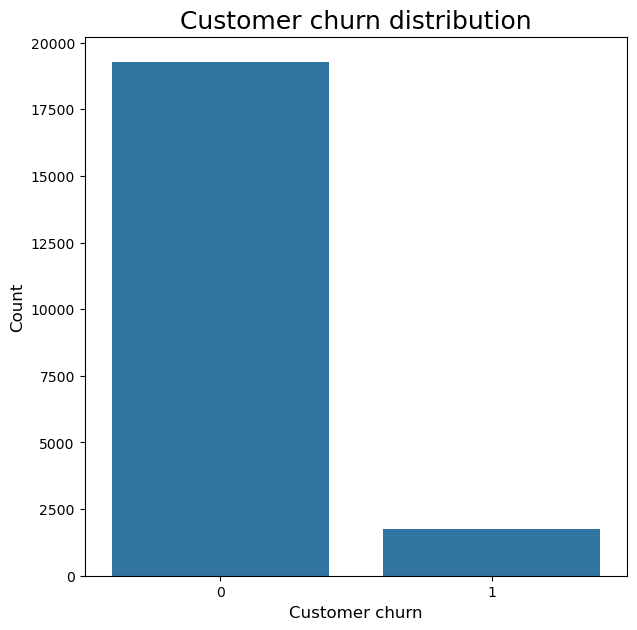

In [48]:
# Visualize churn distribution
plt.figure(figsize=(7, 7))
sns.countplot(x = high_val_train['churn_probability'])
plt.xlabel('Customer churn', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.title('Customer churn distribution', fontsize=18)
plt.show()

#### Based on the visualization, it's evident that 91.73% of customers are non-churn, while 8.26% of customers churn. This indicates a noticeable class imbalance, which we will address later.

In [49]:
# Create a copy of high_val_train df and use the new df (churn_data) for pruning in the training set
churn_data = high_val_train.copy()
churn_data.reset_index(inplace=True)
churn_data.drop(['index'], axis=1, inplace=True)

In [50]:
churn_data.shape

(20998, 149)

In [51]:
# Get the list of columns with missing values in the training set
mv = round(100*(churn_data.isnull().sum(axis=0)/churn_data.shape[0]), 2)
s = mv.loc[mv>0]
impute_cols_num = list(s.index)
len(impute_cols_num)

81

In [52]:
# Lets try to verify how many values are missing from the dataframe
drop = high_val_train.dropna()
print(churn_data.shape[0] - drop.shape[0])

1061


### Impute missing values using KNN Imputer - Training Set

We cannot discard these missing values because doing so would result in the loss of valuable information. Instead, we will employ imputation techniques such as KNNImputer.

KNNImputer is a technique used to impute missing values in a dataset based on the values of its nearest neighbors. It works by identifying the k nearest neighbors of each data point with missing values, then averaging or taking a weighted average of the available values from those neighbors to fill in the missing value. This approach leverages the similarity between data points to estimate the missing values more accurately.

In [53]:
# Create imputer instance
imputer = KNNImputer(n_neighbors=5)

In [54]:
# Separate df having columns to be imputed
df_num = churn_data[impute_cols_num]
churn_df = churn_data.drop(impute_cols_num, axis=1)

In [55]:
%%time
# Impute using KNN imputer instance
df_imp = imputer.fit_transform(df_num)

CPU times: user 9.31 s, sys: 3.9 s, total: 13.2 s
Wall time: 9.95 s


In [56]:
# Convert it to df post imputation
df_imp = pd.DataFrame(df_imp, columns=impute_cols_num)
df_imp.head()

onnet_mou_6  onnet_mou_7  onnet_mou_8  offnet_mou_6  offnet_mou_7  \
0        21.28         4.83         6.13         56.99         38.11   
1        10.43        24.99       194.43        317.11        341.79   
2       859.53       372.71         0.89        293.46        450.11   
3        93.18        38.29        29.86        531.19        507.76   
4         8.58        11.48        12.68        133.16        158.73   

   offnet_mou_8  roam_ic_mou_6  roam_ic_mou_7  roam_ic_mou_8  roam_og_mou_6  \
0          9.63          53.64            0.0            0.0          15.73   
1        197.09           0.00            0.0            0.0           0.00   
2        386.91           0.00            0.0            0.0           0.00   
3        222.03           0.00            0.0            0.0           0.00   
4        182.83           0.00            0.0            0.0           0.00   

   roam_og_mou_7  roam_og_mou_8  loc_og_t2t_mou_6  loc_og_t2t_mou_7  \
0            0.0            0.0             10.16              4.83   
1            0.0            0.0             10.43             24.99   
2            0.0            0.0            859.53            372.71   
3            0.0            0.0             93.18             38.29   
4            0.0            0.0              8.58             11.48   

   loc_og_t2t_mou_8  loc_og_t2m_mou_6  loc_og_t2m_mou_7  loc_og_t2m_mou_8  \
0              6.13             36.74             19.88              4.61   
1            194.43            313.76            330.88            185.88   
2              0.89             79.79            424.63            378.01   
3             29.86            159.29            219.44             99.86   
4             12.68             96.91            149.44            157.23   

   loc_og_t2f_mou_6  loc_og_t2f_mou_7  loc_og_t2f_mou_8  loc_og_t2c_mou_6  \
0             11.99              1.23              5.01               0.0   
1              3.26             10.91              4.94               0.0   
2             11.58             25.43              8.88               0.0   
3              0.00              0.00              0.00               0.0   
4             33.71              9.28             25.59               0.0   

   loc_og_t2c_mou_7  loc_og_t2c_mou_8  loc_og_mou_6  loc_og_mou_7  \
0              9.85              0.00         58.91         25.94   
1              0.00              0.00        327.46        366.79   
2              0.00              0.00        950.91        822.78   
3              0.00              0.36        252.48        257.74   
4              0.00              0.00        139.21        170.21   

   loc_og_mou_8  std_og_t2t_mou_6  std_og_t2t_mou_7  std_og_t2t_mou_8  \
0         15.76               0.0               0.0               0.0   
1        385.26               0.0               0.0               0.0   
2        387.79               0.0               0.0               0.0   
3        129.73               0.0               0.0               0.0   
4        195.51               0.0               0.0               0.0   

   std_og_t2m_mou_6  std_og_t2m_mou_7  std_og_t2m_mou_8  std_og_t2f_mou_6  \
0              4.35              0.00              0.00               0.0   
1              0.00              0.00              0.00               0.0   
2            202.08              0.00              0.00               0.0   
3            371.89            288.31            121.79               0.0   
4              2.53              0.00              0.00               0.0   

   std_og_t2f_mou_7  std_og_t2f_mou_8  std_og_mou_6  std_og_mou_7  \
0               0.0              0.00          4.35          0.00   
1               0.0              6.26          0.00          0.00   
2               0.0              0.00        202.08          0.00   
3               0.0              0.00        371.89        288.31   
4               0.0              0.00          2.53          0.00   

   std_og_

In [57]:
# Merge the two dataframes together post imputation to create the final training set
final_df = pd.concat([df_imp, churn_df], join='inner', axis=1)
final_df.head()

onnet_mou_6  onnet_mou_7  onnet_mou_8  offnet_mou_6  offnet_mou_7  \
0        21.28         4.83         6.13         56.99         38.11   
1        10.43        24.99       194.43        317.11        341.79   
2       859.53       372.71         0.89        293.46        450.11   
3        93.18        38.29        29.86        531.19        507.76   
4         8.58        11.48        12.68        133.16        158.73   

   offnet_mou_8  roam_ic_mou_6  roam_ic_mou_7  roam_ic_mou_8  roam_og_mou_6  \
0          9.63          53.64            0.0            0.0          15.73   
1        197.09           0.00            0.0            0.0           0.00   
2        386.91           0.00            0.0            0.0           0.00   
3        222.03           0.00            0.0            0.0           0.00   
4        182.83           0.00            0.0            0.0           0.00   

   roam_og_mou_7  roam_og_mou_8  loc_og_t2t_mou_6  loc_og_t2t_mou_7  \
0            0.0            0.0             10.16              4.83   
1            0.0            0.0             10.43             24.99   
2            0.0            0.0            859.53            372.71   
3            0.0            0.0             93.18             38.29   
4            0.0            0.0              8.58             11.48   

   loc_og_t2t_mou_8  loc_og_t2m_mou_6  loc_og_t2m_mou_7  loc_og_t2m_mou_8  \
0              6.13             36.74             19.88              4.61   
1            194.43            313.76            330.88            185.88   
2              0.89             79.79            424.63            378.01   
3             29.86            159.29            219.44             99.86   
4             12.68             96.91            149.44            157.23   

   loc_og_t2f_mou_6  loc_og_t2f_mou_7  loc_og_t2f_mou_8  loc_og_t2c_mou_6  \
0             11.99              1.23              5.01               0.0   
1              3.26             10.91              4.94               0.0   
2             11.58             25.43              8.88               0.0   
3              0.00              0.00              0.00               0.0   
4             33.71              9.28             25.59               0.0   

   loc_og_t2c_mou_7  loc_og_t2c_mou_8  loc_og_mou_6  loc_og_mou_7  \
0              9.85              0.00         58.91         25.94   
1              0.00              0.00        327.46        366.79   
2              0.00              0.00        950.91        822.78   
3              0.00              0.36        252.48        257.74   
4              0.00              0.00        139.21        170.21   

   loc_og_mou_8  std_og_t2t_mou_6  std_og_t2t_mou_7  std_og_t2t_mou_8  \
0         15.76               0.0               0.0               0.0   
1        385.26               0.0               0.0               0.0   
2        387.79               0.0               0.0               0.0   
3        129.73               0.0               0.0               0.0   
4        195.51               0.0               0.0               0.0   

   std_og_t2m_mou_6  std_og_t2m_mou_7  std_og_t2m_mou_8  std_og_t2f_mou_6  \
0              4.35              0.00              0.00               0.0   
1              0.00              0.00              0.00               0.0   
2            202.08              0.00              0.00               0.0   
3            371.89            288.31            121.79               0.0   
4              2.53              0.00              0.00               0.0   

   std_og_t2f_mou_7  std_og_t2f_mou_8  std_og_mou_6  std_og_mou_7  \
0               0.0              0.00          4.35          0.00   
1               0.0              6.26          0.00          0.00   
2               0.0              0.00        202.08          0.00   
3               0.0              0.00        371.89        288.31   
4               0.0              0.00          2.53          0.00   

   std_og_

In [58]:
final_df.shape

(20998, 149)

In [59]:
# Verify no missing value is present in the training set now
final_df.isnull().sum().sort_values(ascending=False)

onnet_mou_6           0
total_rech_amt_7      0
max_rech_amt_6        0
max_rech_amt_7        0
max_rech_amt_8        0
last_day_rch_amt_6    0
last_day_rch_amt_7    0
last_day_rch_amt_8    0
max_rech_data_6       0
max_rech_data_7       0
max_rech_data_8       0
count_rech_2g_6       0
count_rech_2g_7       0
count_rech_2g_8       0
count_rech_3g_6       0
count_rech_3g_7       0
count_rech_3g_8       0
total_rech_amt_8      0
total_rech_amt_6      0
isd_ic_mou_6          0
total_rech_num_8      0
isd_ic_mou_8          0
ic_others_6           0
ic_others_7           0
ic_others_8           0
arpu_6                0
arpu_7                0
arpu_8                0
total_og_mou_6        0
total_og_mou_7        0
total_og_mou_8        0
total_ic_mou_6        0
total_ic_mou_7        0
total_ic_mou_8        0
total_rech_num_6      0
total_rech_num_7      0
vol_2g_mb_6           0
vol_2g_mb_7           0
vol_2g_mb_8           0
vol_3g_mb_6           0
monthly_3g_7          0
monthly_3g_8    

### Impute missing values using the KNN Imputer - Unseen Test Set

In [60]:
# Separate df having columns to be imputed
df_num_unseen = unseen[impute_cols_num]
churn_df_unseen = unseen.drop(impute_cols_num, axis=1)

In [61]:
%%time
# Impute using KNN imputer instance
df_imp_unseen = imputer.transform(df_num_unseen)

CPU times: user 21.3 s, sys: 11.6 s, total: 32.9 s
Wall time: 27.7 s


In [62]:
# Convert it to df post imputation
df_imp_unseen = pd.DataFrame(df_imp_unseen, columns=impute_cols_num)
df_imp_unseen.head()

onnet_mou_6  onnet_mou_7  onnet_mou_8  offnet_mou_6  offnet_mou_7  \
0        31.78        20.23        23.11         60.16         32.16   
1        75.51        41.21        19.84        474.34        621.84   
2         7.54         7.86         8.40         16.98         45.81   
3         5.31         2.16         0.00         40.04        205.01   
4       450.93       609.03       700.68         60.94         23.84   

   offnet_mou_8  roam_ic_mou_6  roam_ic_mou_7  roam_ic_mou_8  roam_og_mou_6  \
0         34.83           0.00           0.00           0.00           0.00   
1        394.94           0.00           0.00           0.00           0.00   
2         45.04          22.81         103.38          26.08          24.53   
3         24.01           0.00           0.00           0.00           0.00   
4         74.16           0.00           0.00           0.00           0.00   

   roam_og_mou_7  roam_og_mou_8  loc_og_t2t_mou_6  loc_og_t2t_mou_7  \
0           0.00           0.00             24.88             20.23   
1           0.00           0.00             75.51             41.21   
2          53.68          54.44              0.00              0.00   
3           0.00           0.00              5.31              0.00   
4           0.00           0.00              0.45              0.78   

   loc_og_t2t_mou_8  loc_og_t2m_mou_6  loc_og_t2m_mou_7  loc_og_t2m_mou_8  \
0             21.06             18.13             10.89              8.36   
1             19.84            473.61            598.08            377.26   
2              0.00              0.00              0.00              0.00   
3              0.00              2.94             98.61             20.51   
4             14.56              2.39              2.66             10.94   

   loc_og_t2f_mou_6  loc_og_t2f_mou_7  loc_og_t2f_mou_8  loc_og_t2c_mou_6  \
0              0.00             13.58              0.00               0.0   
1              0.73              0.00              0.00               0.0   
2              0.00              0.00              0.00               0.0   
3              0.00              0.00              2.35               0.0   
4              0.00              0.00              0.00               0.0   

   loc_og_t2c_mou_7  loc_og_t2c_mou_8  loc_og_mou_6  loc_og_mou_7  \
0              0.00              0.03         43.01         44.71   
1              0.00              0.00        549.86        639.29   
2              0.00              0.00          0.00          0.00   
3              6.18              0.00          8.26         98.61   
4              0.00              0.00          2.84          3.44   

   loc_og_mou_8  std_og_t2t_mou_6  std_og_t2t_mou_7  std_og_t2t_mou_8  \
0         29.43              6.90              0.00              2.05   
1        397.11              0.00              0.00              0.00   
2          0.00              0.00              0.00              0.00   
3         22.86              0.00              2.16              0.00   
4         25.51            450.48            608.24            686.11   

   std_og_t2m_mou_6  std_og_t2m_mou_7  std_og_t2m_mou_8  std_og_t2f_mou_6  \
0             42.03              7.68             26.43               0.0   
1              0.00             23.76             17.68               0.0   
2              0.00              0.00              0.00               0.0   
3             37.09             94.36              0.00               0.0   
4             58.54             21.18             63.18               0.0   

   std_og_t2f_mou_7  std_og_t2f_mou_8  std_og_mou_6  std_og_mou_7  \
0               0.0               0.0         48.93          7.68   
1               0.0               0.0          0.00         23.76   
2               0.0               0.0          0.00          0.00   
3               0.0               0.0         37.09         96.53   
4               0.0               0.0        509.03        629.43   

   std_og_

In [63]:
# Merge the two dataframes together post imputation
final_unseen_df = pd.concat([df_imp_unseen, churn_df_unseen], join='inner', axis=1)
final_unseen_df.head()

onnet_mou_6  onnet_mou_7  onnet_mou_8  offnet_mou_6  offnet_mou_7  \
0        31.78        20.23        23.11         60.16         32.16   
1        75.51        41.21        19.84        474.34        621.84   
2         7.54         7.86         8.40         16.98         45.81   
3         5.31         2.16         0.00         40.04        205.01   
4       450.93       609.03       700.68         60.94         23.84   

   offnet_mou_8  roam_ic_mou_6  roam_ic_mou_7  roam_ic_mou_8  roam_og_mou_6  \
0         34.83           0.00           0.00           0.00           0.00   
1        394.94           0.00           0.00           0.00           0.00   
2         45.04          22.81         103.38          26.08          24.53   
3         24.01           0.00           0.00           0.00           0.00   
4         74.16           0.00           0.00           0.00           0.00   

   roam_og_mou_7  roam_og_mou_8  loc_og_t2t_mou_6  loc_og_t2t_mou_7  \
0           0.00           0.00             24.88             20.23   
1           0.00           0.00             75.51             41.21   
2          53.68          54.44              0.00              0.00   
3           0.00           0.00              5.31              0.00   
4           0.00           0.00              0.45              0.78   

   loc_og_t2t_mou_8  loc_og_t2m_mou_6  loc_og_t2m_mou_7  loc_og_t2m_mou_8  \
0             21.06             18.13             10.89              8.36   
1             19.84            473.61            598.08            377.26   
2              0.00              0.00              0.00              0.00   
3              0.00              2.94             98.61             20.51   
4             14.56              2.39              2.66             10.94   

   loc_og_t2f_mou_6  loc_og_t2f_mou_7  loc_og_t2f_mou_8  loc_og_t2c_mou_6  \
0              0.00             13.58              0.00               0.0   
1              0.73              0.00              0.00               0.0   
2              0.00              0.00              0.00               0.0   
3              0.00              0.00              2.35               0.0   
4              0.00              0.00              0.00               0.0   

   loc_og_t2c_mou_7  loc_og_t2c_mou_8  loc_og_mou_6  loc_og_mou_7  \
0              0.00              0.03         43.01         44.71   
1              0.00              0.00        549.86        639.29   
2              0.00              0.00          0.00          0.00   
3              6.18              0.00          8.26         98.61   
4              0.00              0.00          2.84          3.44   

   loc_og_mou_8  std_og_t2t_mou_6  std_og_t2t_mou_7  std_og_t2t_mou_8  \
0         29.43              6.90              0.00              2.05   
1        397.11              0.00              0.00              0.00   
2          0.00              0.00              0.00              0.00   
3         22.86              0.00              2.16              0.00   
4         25.51            450.48            608.24            686.11   

   std_og_t2m_mou_6  std_og_t2m_mou_7  std_og_t2m_mou_8  std_og_t2f_mou_6  \
0             42.03              7.68             26.43               0.0   
1              0.00             23.76             17.68               0.0   
2              0.00              0.00              0.00               0.0   
3             37.09             94.36              0.00               0.0   
4             58.54             21.18             63.18               0.0   

   std_og_t2f_mou_7  std_og_t2f_mou_8  std_og_mou_6  std_og_mou_7  \
0               0.0               0.0         48.93          7.68   
1               0.0               0.0          0.00         23.76   
2               0.0               0.0          0.00          0.00   
3               0.0               0.0         37.09         96.53   
4               0.0               0.0        509.03        629.43   

   std_og_

In [64]:
final_unseen_df.shape

(30000, 149)

In [65]:
# Verify no missing value is present in the test set now
final_unseen_df.isnull().sum().sort_values(ascending=False)

onnet_mou_6           0
total_rech_amt_6      0
total_rech_amt_8      0
max_rech_amt_6        0
max_rech_amt_7        0
max_rech_amt_8        0
last_day_rch_amt_6    0
last_day_rch_amt_7    0
last_day_rch_amt_8    0
max_rech_data_6       0
max_rech_data_7       0
max_rech_data_8       0
count_rech_2g_6       0
count_rech_2g_7       0
count_rech_2g_8       0
count_rech_3g_6       0
count_rech_3g_7       0
total_rech_amt_7      0
total_rech_num_8      0
isd_ic_mou_6          0
total_rech_num_7      0
isd_ic_mou_8          0
ic_others_6           0
ic_others_7           0
ic_others_8           0
id                    0
arpu_6                0
arpu_7                0
arpu_8                0
total_og_mou_6        0
total_og_mou_7        0
total_og_mou_8        0
total_ic_mou_6        0
total_ic_mou_7        0
total_ic_mou_8        0
total_rech_num_6      0
count_rech_3g_8       0
vol_2g_mb_6           0
vol_2g_mb_7           0
vol_2g_mb_8           0
monthly_3g_6          0
monthly_3g_7    

#### There is no missing values in the dataset now. Let's perform Exploratory Data Analysis and Outlier Treatment.

### 3. Common Utility Methods

In [66]:
def plot_bar_graph(title, month, y_list, data):
    """
    Plot bar graphs for given data.

    Parameters:
    - title (str): Title of the plot.
    - month (list of str): List of month names.
    - y_list (list of str): List of y-variable names corresponding to each month.
    - data (DataFrame): DataFrame containing the data to be plotted.

    Returns:
    - None

    This function plots bar graphs for each month's data based on the provided y-variables.
    It creates subplots for each month, with the corresponding y-variable plotted against 'churn_probability'.
    The title of each subplot includes the specified title along with the month name.
    """
    plt.figure(figsize=(15, 10))
    
    for i, m in enumerate(month):
        plt.subplot(2, 3, i+1)
        plt.title(f'{title} for {m}')
        sns.barplot(x='churn_probability', y=y_list[i], data=data)
    
    plt.tight_layout()
    plt.show()

In [67]:
def outlier_handling(dataframe):
    """
    Applies outlier handling transformations to the values in the given DataFrame.

    Parameters:
    - dataframe (DataFrame): The DataFrame containing the values to be transformed.

    Returns:
    - transformed_values (list): A list containing the transformed values based on the specified conditions.
    """

    transformed_values = []
    for value in dataframe:
        if value <= 0:
            transformed_values.append(float(0))
        elif float(value) == float(1.0):
            transformed_values.append(float(1.5))
        else:
            transformed_values.append(float(np.log1p(value)))

    return transformed_values

In [68]:
def calculate_classification_metrics(y_true, y_pred):
    """
    Calculate various classification metrics.

    Parameters:
    y_true (array-like): True labels.
    y_pred (array-like): Predicted labels.

    Returns:
    pd.DataFrame: A DataFrame containing the calculated metrics.
    """
    # Confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    print('Confusion Matrix')
    print()
    print(cm)
    
    # True Positives, False Positives, True Negatives, False Negatives
    TP = cm[1, 1]
    FP = cm[0, 1]
    TN = cm[0, 0]
    FN = cm[1, 0]

    # Accuracy Score
    accuracy = round((TP + TN) / (TP + FP + TN + FN), 4)

    # Sensitivity (Recall or True Positive Rate)
    sensitivity = round(TP / (TP + FN), 4)

    # Specificity
    specificity = round(TN / (TN + FP), 4)

    # Precision
    precision = round(TP / (TP + FP), 4)

    # False Positive Rate
    false_positive_rate = round(FP / (FP + TN), 4)

    # True Positive Rate
    true_positive_rate = sensitivity

    metrics_df = pd.DataFrame({
        'Metric': ['Accuracy', 'Sensitivity', 'Specificity', 'Precision', 'False Positive Rate', 'True Positive Rate'],
        'Value': [accuracy, sensitivity, specificity, precision, false_positive_rate, true_positive_rate]
    })

    return metrics_df

In [69]:
def draw_roc(actual, probs):
    fpr, tpr, thresholds = roc_curve(actual, probs,drop_intermediate = False)
    auc_score = roc_auc_score( actual, probs )
    plt.figure(figsize=(6, 6))
    plt.plot( fpr, tpr, label='ROC curve (area = %0.2f)' % auc_score)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate or [1 - True Negative Rate]')
    plt.ylabel('True Positive Rate')
    plt.title('ROC AUC Curve')
    plt.legend(loc="lower right")
    plt.show()

    return fpr, tpr, thresholds

### 4. Exploratory Data Analysis (EDA)

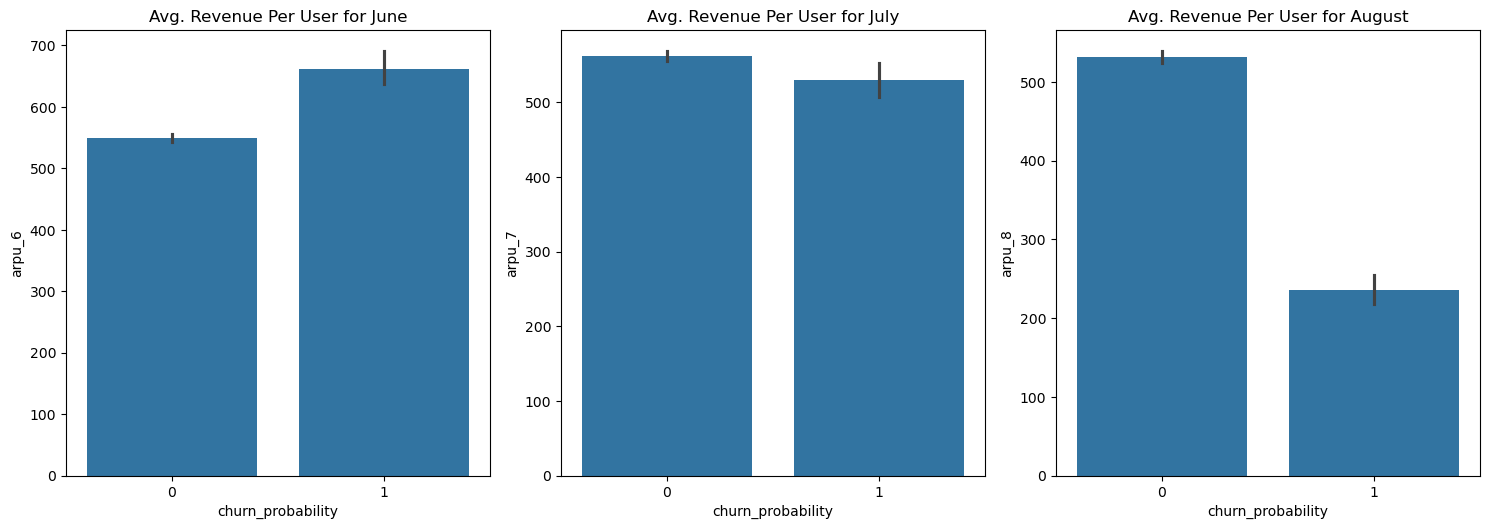

In [70]:
# Visualising Average Revenue per user
arpu_cols = ['arpu_6', 'arpu_7', 'arpu_8']
plot_bar_graph('Avg. Revenue Per User', ['June', 'July', 'August'], arpu_cols, final_df)

##### The decline in the Average Revenue Per User (ARPU) in month of August suggests churn.

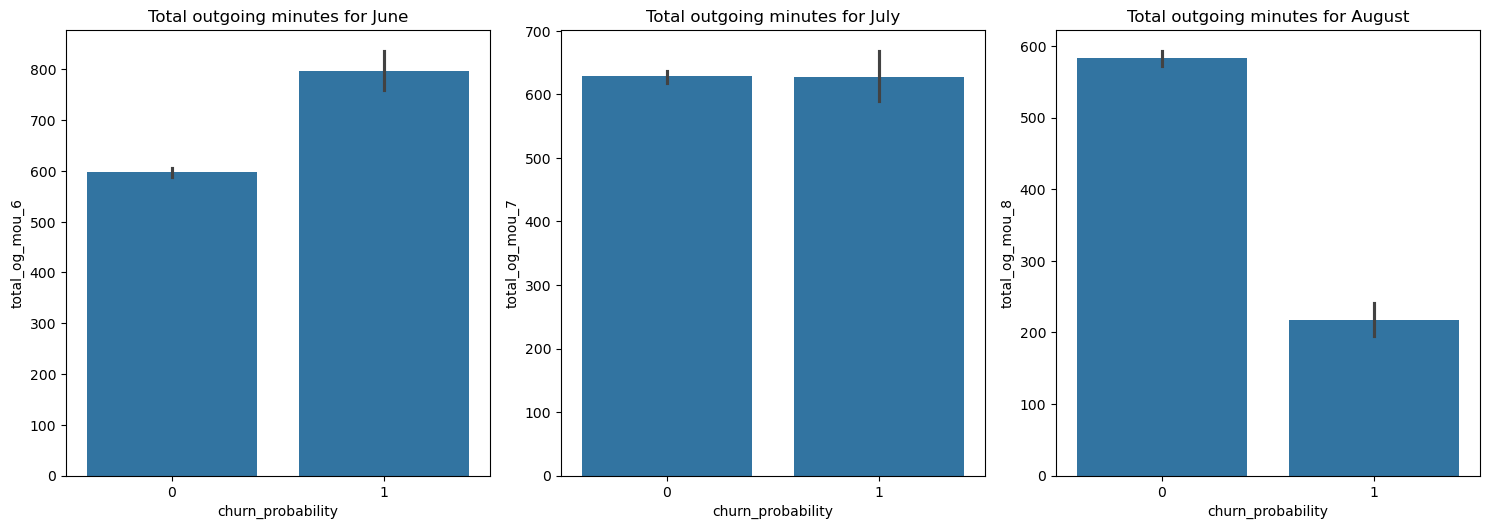

In [71]:
# Visualising Outgoing minutes of usage
total_og_mou_cols = ['total_og_mou_6', 'total_og_mou_7', 'total_og_mou_8']
plot_bar_graph('Total outgoing minutes', ['June', 'July', 'August'], total_og_mou_cols, final_df)

##### The decline in the Total outgoing minutes in month of August suggests churn.

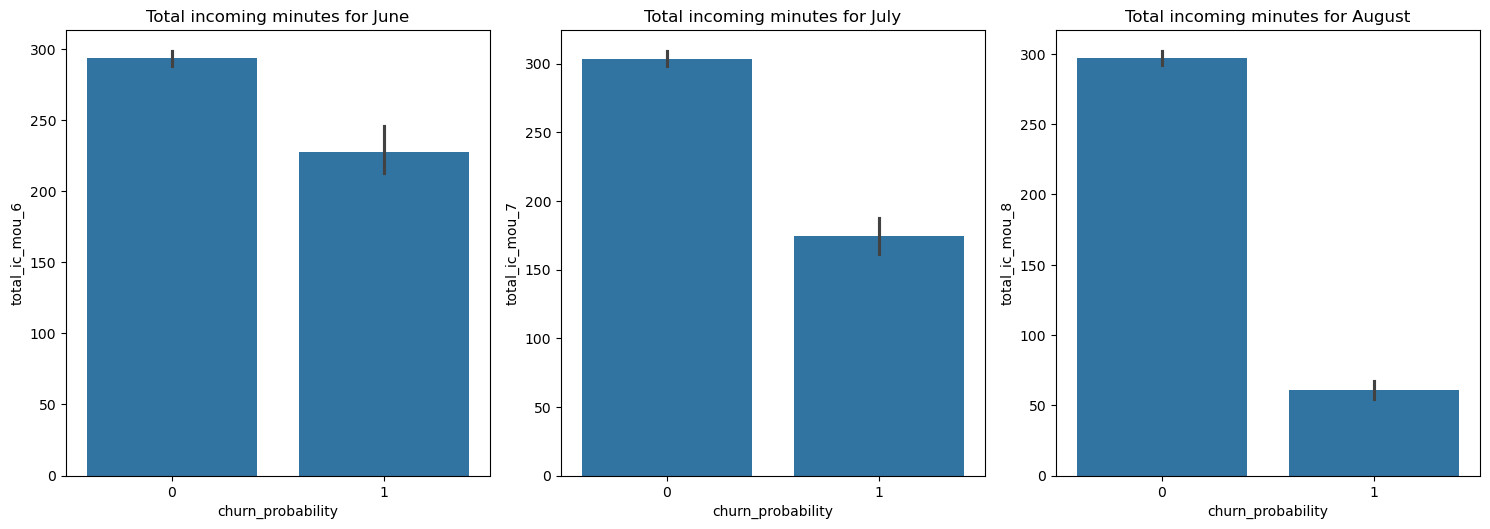

In [72]:
# Visualising incoming minutes of usage
total_ic_mou_cols = ['total_ic_mou_6', 'total_ic_mou_7', 'total_ic_mou_8']
plot_bar_graph('Total incoming minutes', ['June', 'July', 'August'], total_ic_mou_cols, final_df)

##### The decline in the Total incoming minutes in month of August suggests churn.

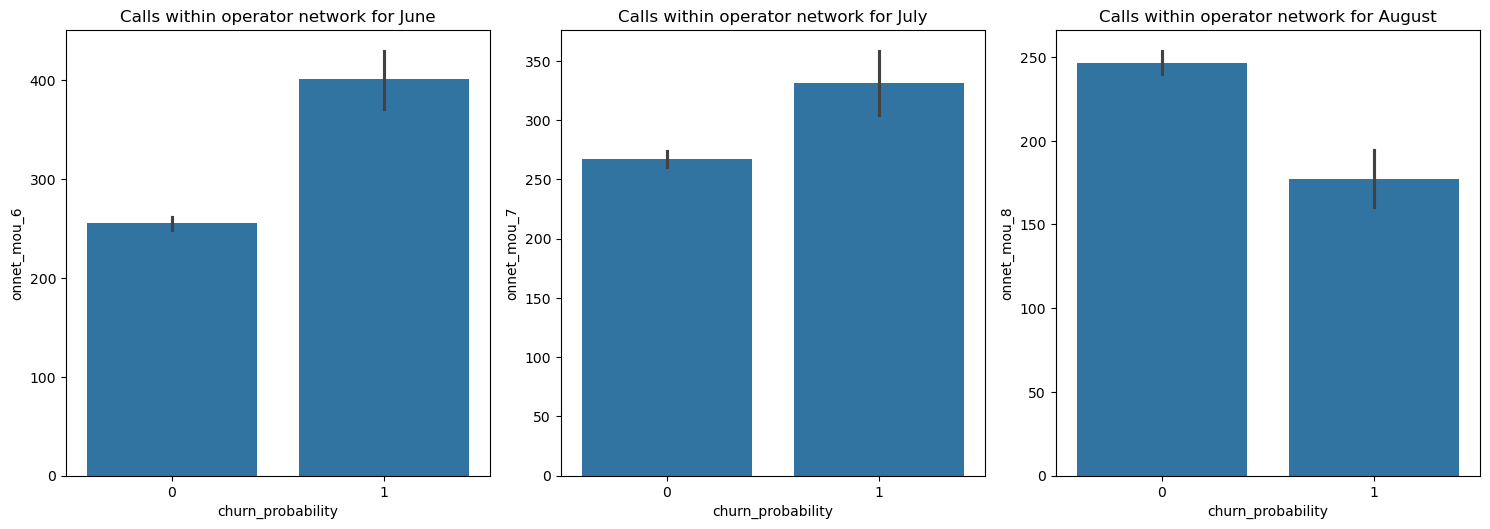

In [73]:
# Visualizing all types of calls within the operator's network.
onnet_mou_cols = ['onnet_mou_6', 'onnet_mou_7', 'onnet_mou_8']
plot_bar_graph('Calls within operator network', ['June', 'July', 'August'], onnet_mou_cols, final_df)

##### The decline in the Calls within operator network in month of August suggests churn.

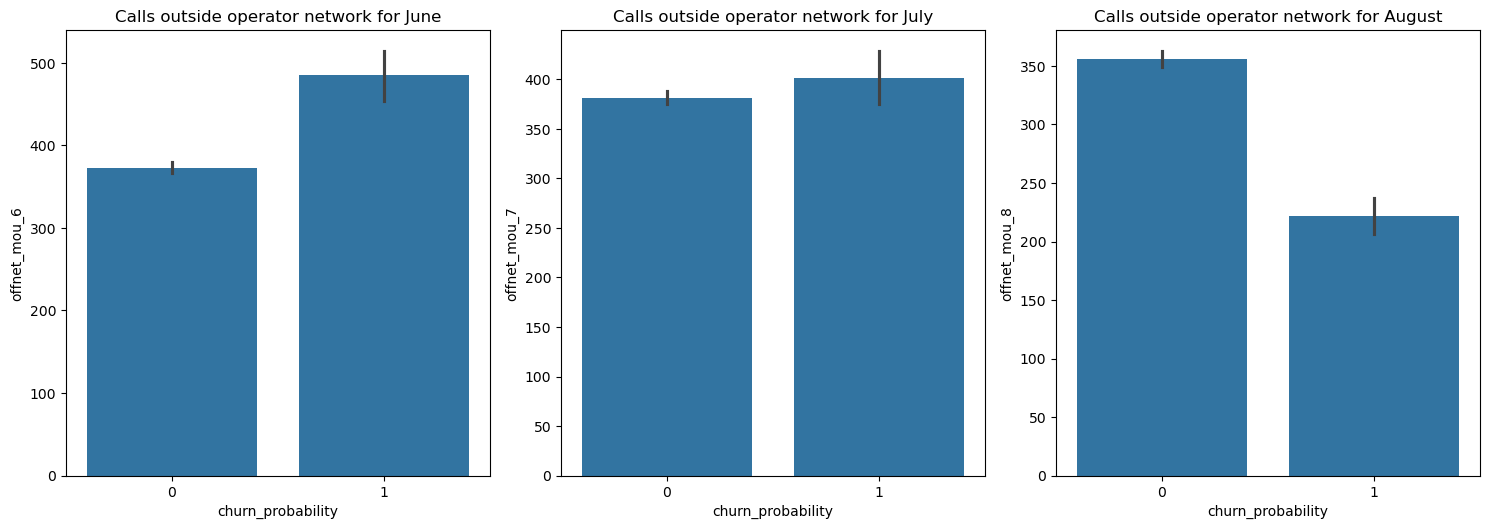

In [74]:
# Visualizing all types of calls made outside the operator network.
offnet_mou_cols = ['offnet_mou_6', 'offnet_mou_7', 'offnet_mou_8']
plot_bar_graph('Calls outside operator network', ['June', 'July', 'August'], offnet_mou_cols, final_df)

##### The decline in the Calls outside operator network in month of August suggests churn.

In [75]:
# Analysing different metrics by extracting them into columns of similar type
amount_data = final_df.loc[:, final_df.columns.str.contains('amt')]
data2g = final_df.loc[:, final_df.columns.str.contains('2g')]
data3g = final_df.loc[:, final_df.columns.str.contains('3g')]
ic_mou_data = final_df.loc[:, final_df.columns.str.contains('ic') & final_df.columns.str.contains('mou')]
net_mou_data = final_df.loc[:, final_df.columns.str.contains('net_mou')]
og_mou_data = final_df.loc[:, final_df.columns.str.contains('og') & final_df.columns.str.contains('mou')]
rech_data = final_df.loc[:, final_df.columns.str.contains('rech')]
total_data = final_df.loc[:, final_df.columns.str.contains('tot')]

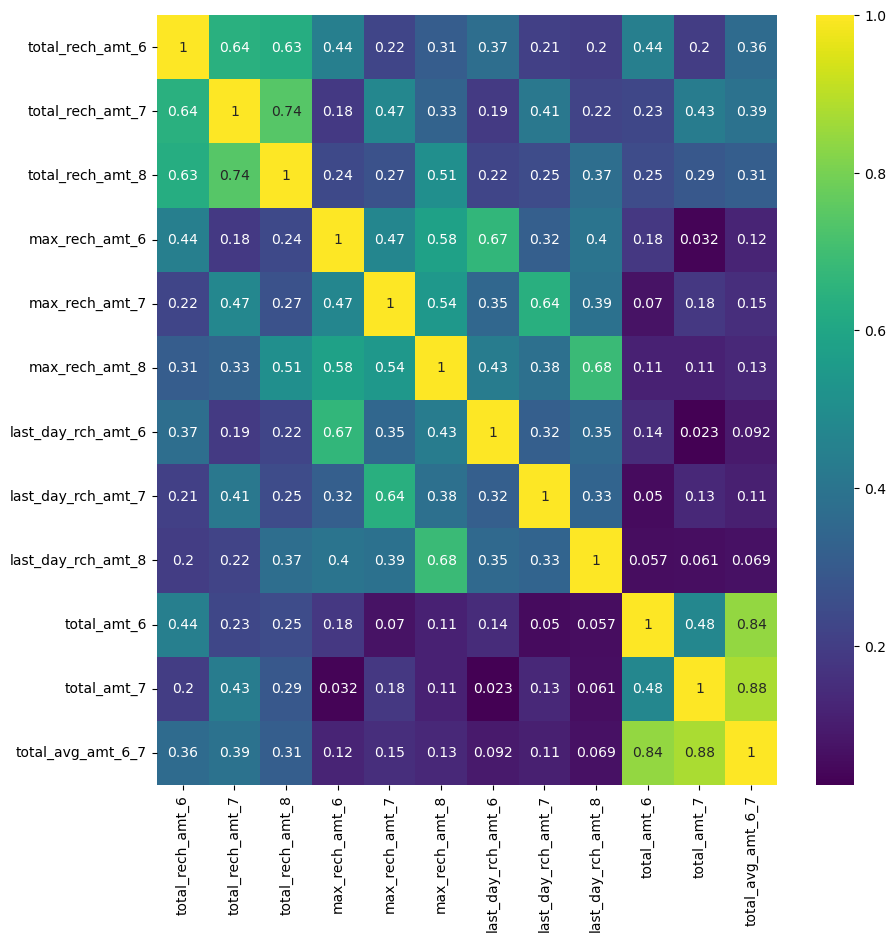

In [76]:
# Amount data
plt.figure(figsize=(10,10))
sns.heatmap(amount_data.corr(), annot=True, cmap='viridis')
plt.show()

***Observations:***
- A substantial correlation of 74% exists between the total recharge amount in month 7 and month 8.
- Similarly, a notable correlation of 68% is observed between the maximum recharge amount in month 8 and the last day's recharge amount in the same month.
- This suggests that customers who are unlikely to churn tend to recharge higher amounts in month 8.

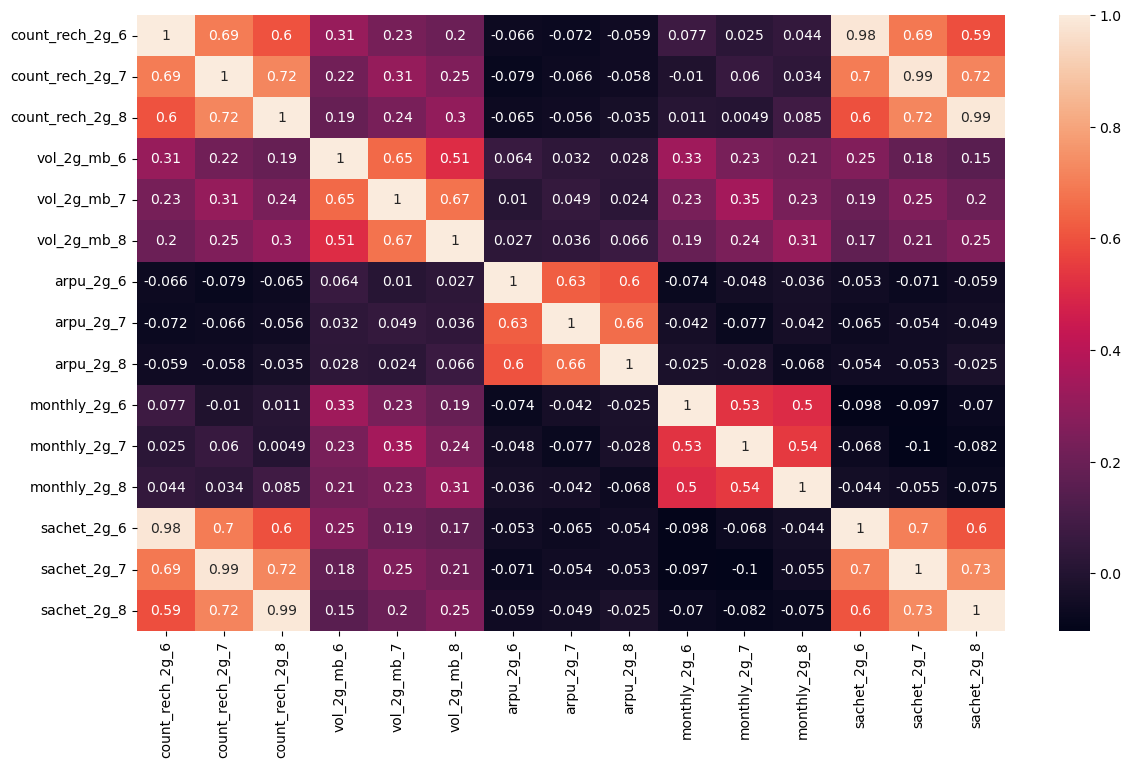

In [77]:
# data2g
plt.figure(figsize=(14,8))
sns.heatmap(data2g.corr(), annot=True)
plt.show()

***Observations:***
- There is a strong correlation between recharge quantities in months 7 and 8.

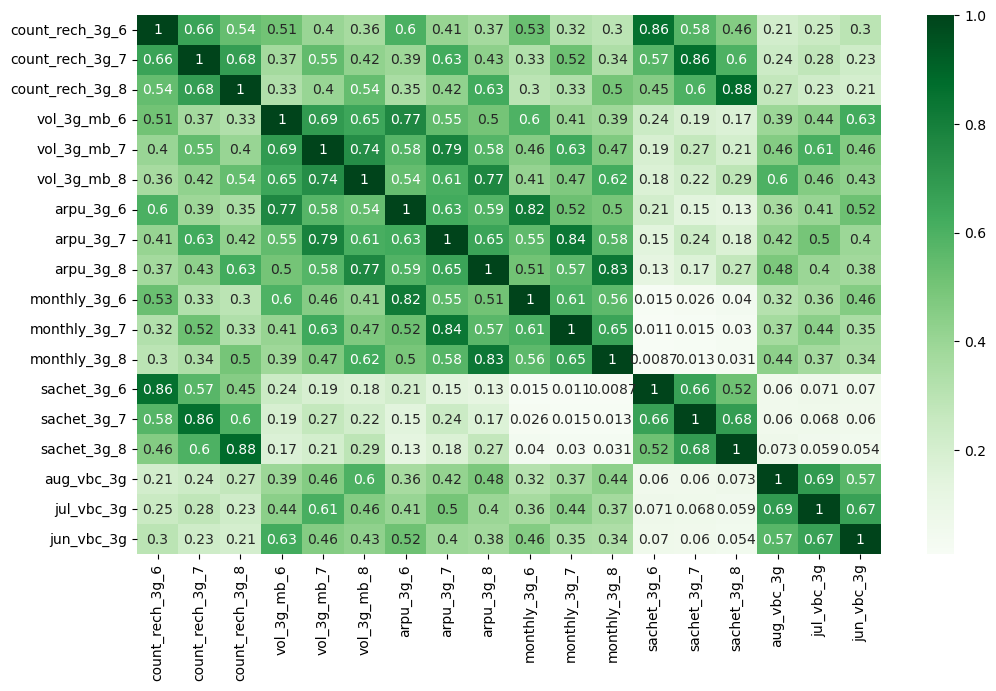

In [78]:
#data3g
plt.figure(figsize=(12,7))
sns.heatmap(data3g.corr(),annot=True, cmap='Greens')
plt.show()

***Observations:***
- There is a strong correlation between recharge quantities in months 7 and 8.

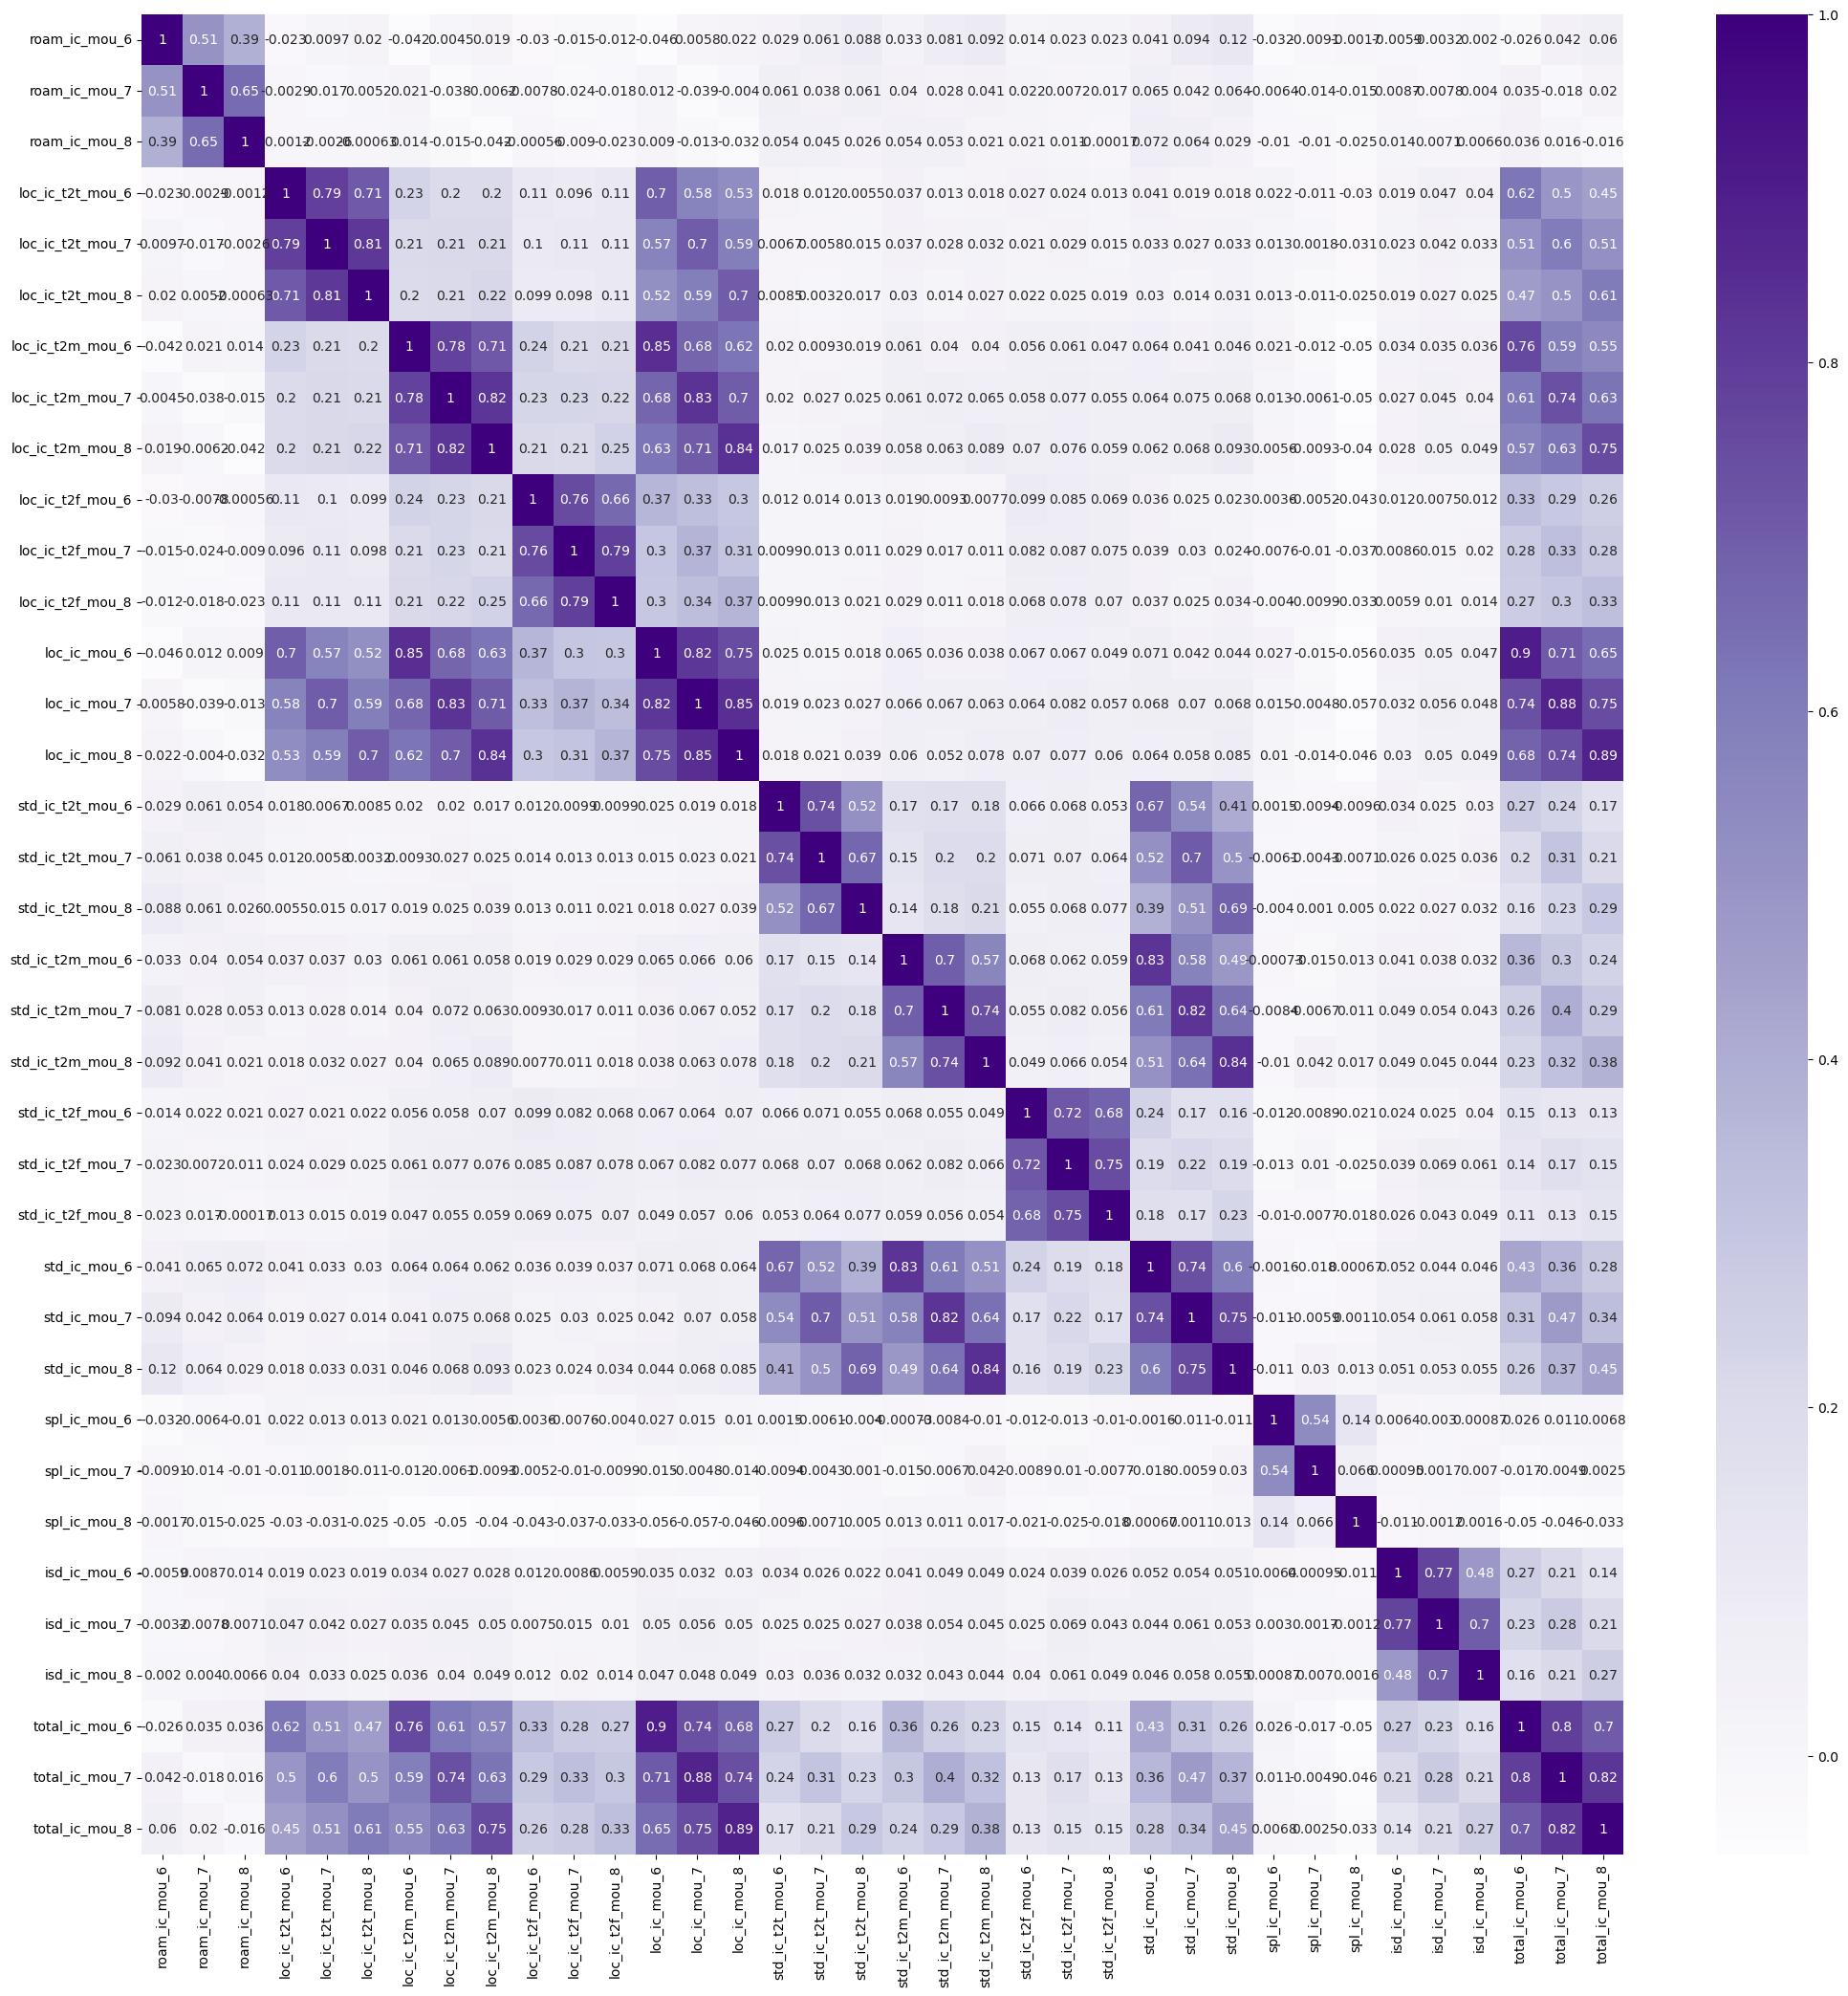

In [79]:
#ic_mou_data
plt.figure(figsize=(25, 25))
sns.heatmap(ic_mou_data.corr(), annot=True, cmap='Purples')
plt.show()

***Observations:*** <br/><br/>
The following variables or features exhibit a remarkably high correlation:

1. total_ic_mou_6 and loc_ic_mou_6
2. total_ic_mou_7 and loc_ic_mou_7
3. total_ic_mou_8 and loc_ic_mou_8
4. std_ic_mou_6 and std_ic_t2f_mou_6
5. std_ic_mou_7 and std_ic_t2f_mou_7
6. std_ic_mou_8 and std_ic_t2f_mou_8

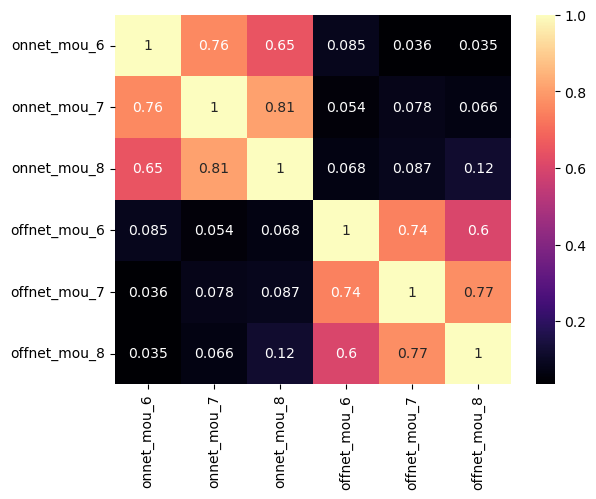

In [80]:
#net_mou_data
sns.heatmap(net_mou_data.corr(), annot=True, cmap='magma')
plt.show()

***Observations:***
- There is no correlation between the usage minutes for on-net and off-net calls.
- However, a significant correlation is observed between the on-net and off-net usage minutes in both months 7 and 8.

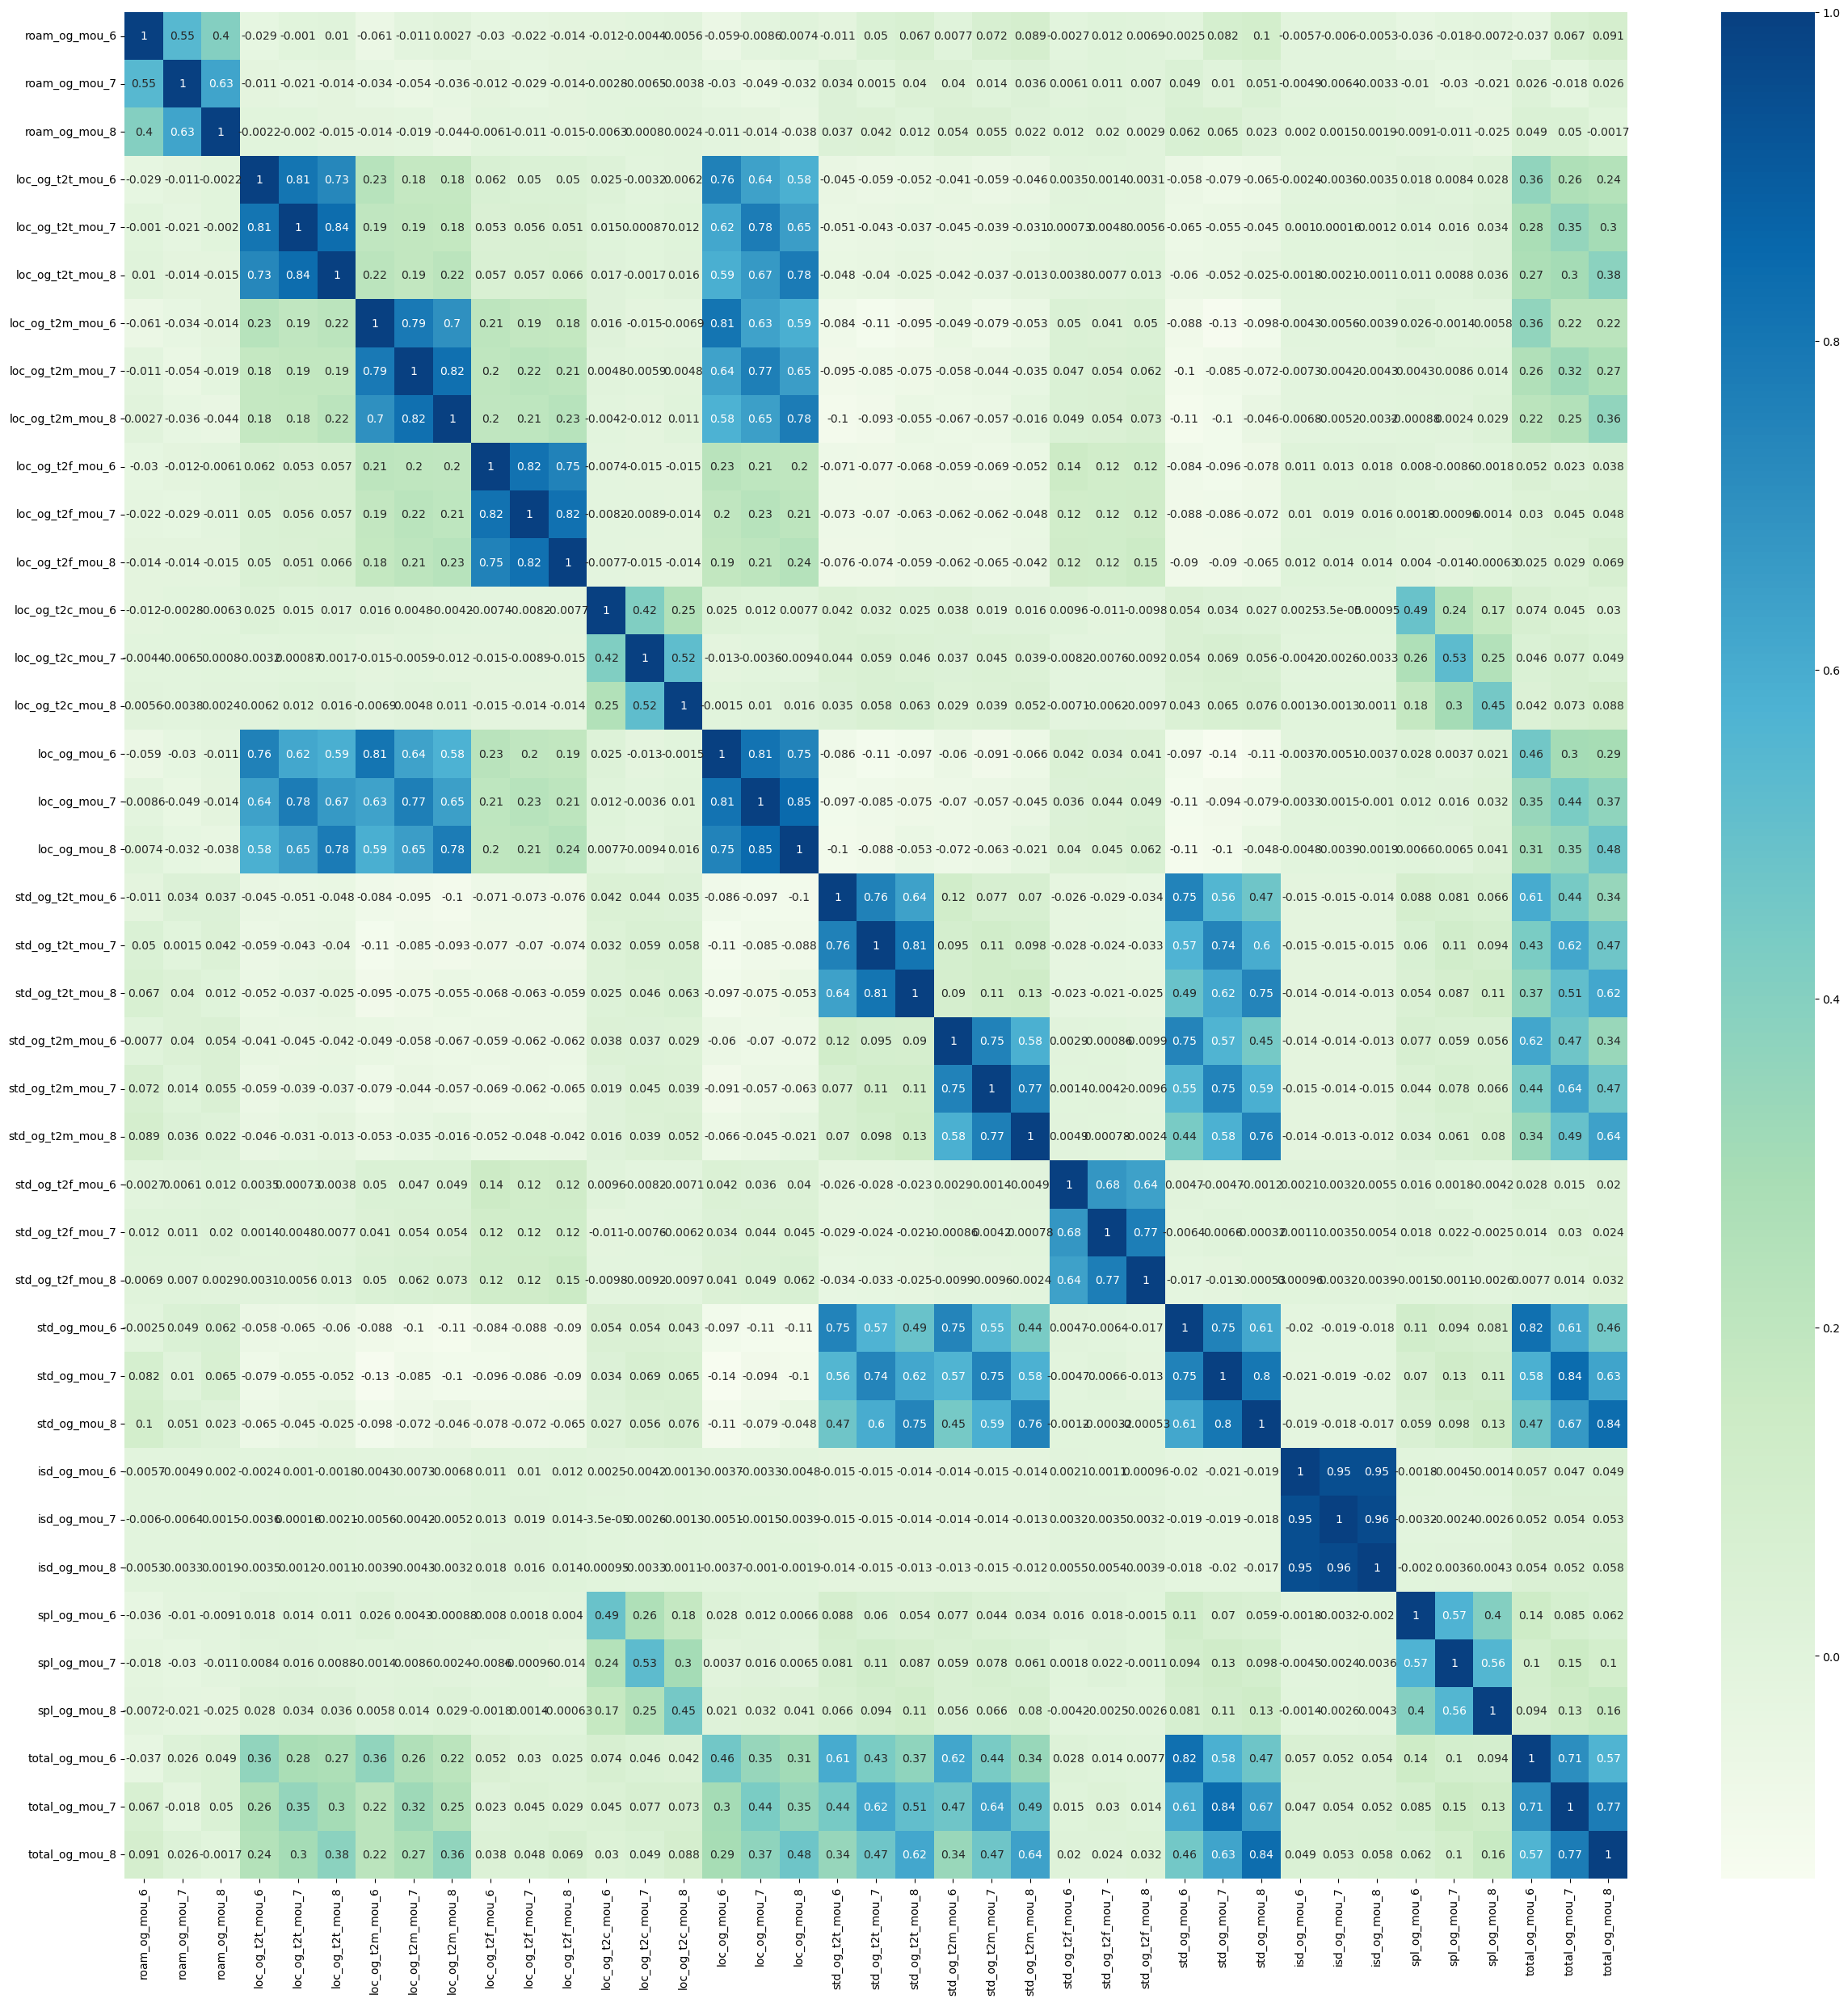

In [81]:
#og_mou_data
plt.figure(figsize=(30,30))
sns.heatmap(og_mou_data.corr(), annot=True, cmap='GnBu')
plt.show()

***Observations:***
- There exists a very high correlation between the following variables/features:
  1. isd_og_mou_7 and isd_og_mou_6
  2. isd_og_mou_8 and isd_og_mou_6
  3. isd_og_mou_8 and isd_og_mou_7
  4. total_og_mou_6 and std_og_mou_6
  5. total_og_mou_7 and std_og_mou_7
  6. total_og_mou_8 and std_og_mou_8

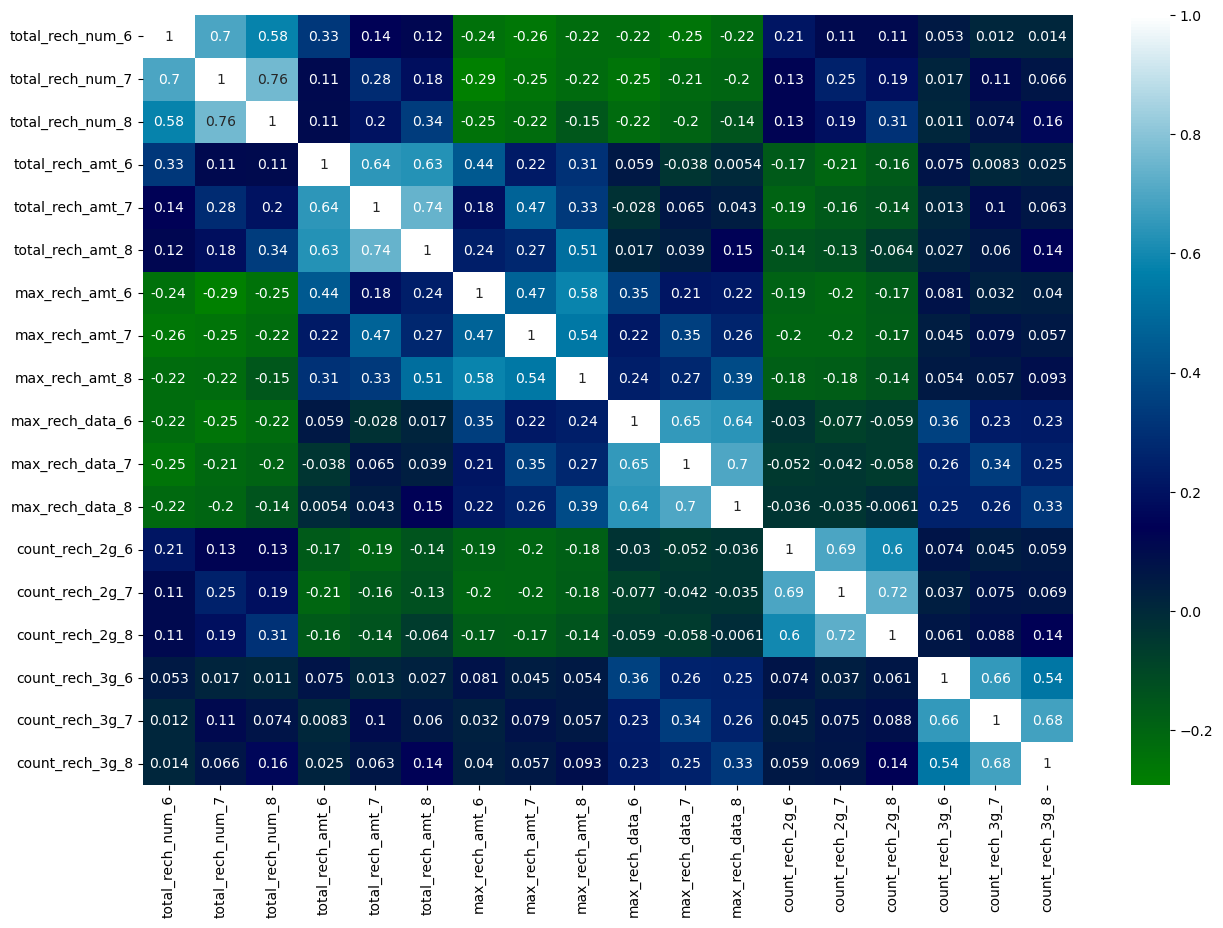

In [82]:
#rech_data
plt.figure(figsize=(15,10))
sns.heatmap(rech_data.corr(), annot=True, cmap='ocean')
plt.show()

***Observations:***
- There is a notable correlation between the average recharge amount and the recharge amount for both months 6 and 7.
- A significant correlation of 76% exists between the total recharge for month 7 and the recharge for month 8.
- Any factor correlated with month 8 is likely correlated with churn prediction.

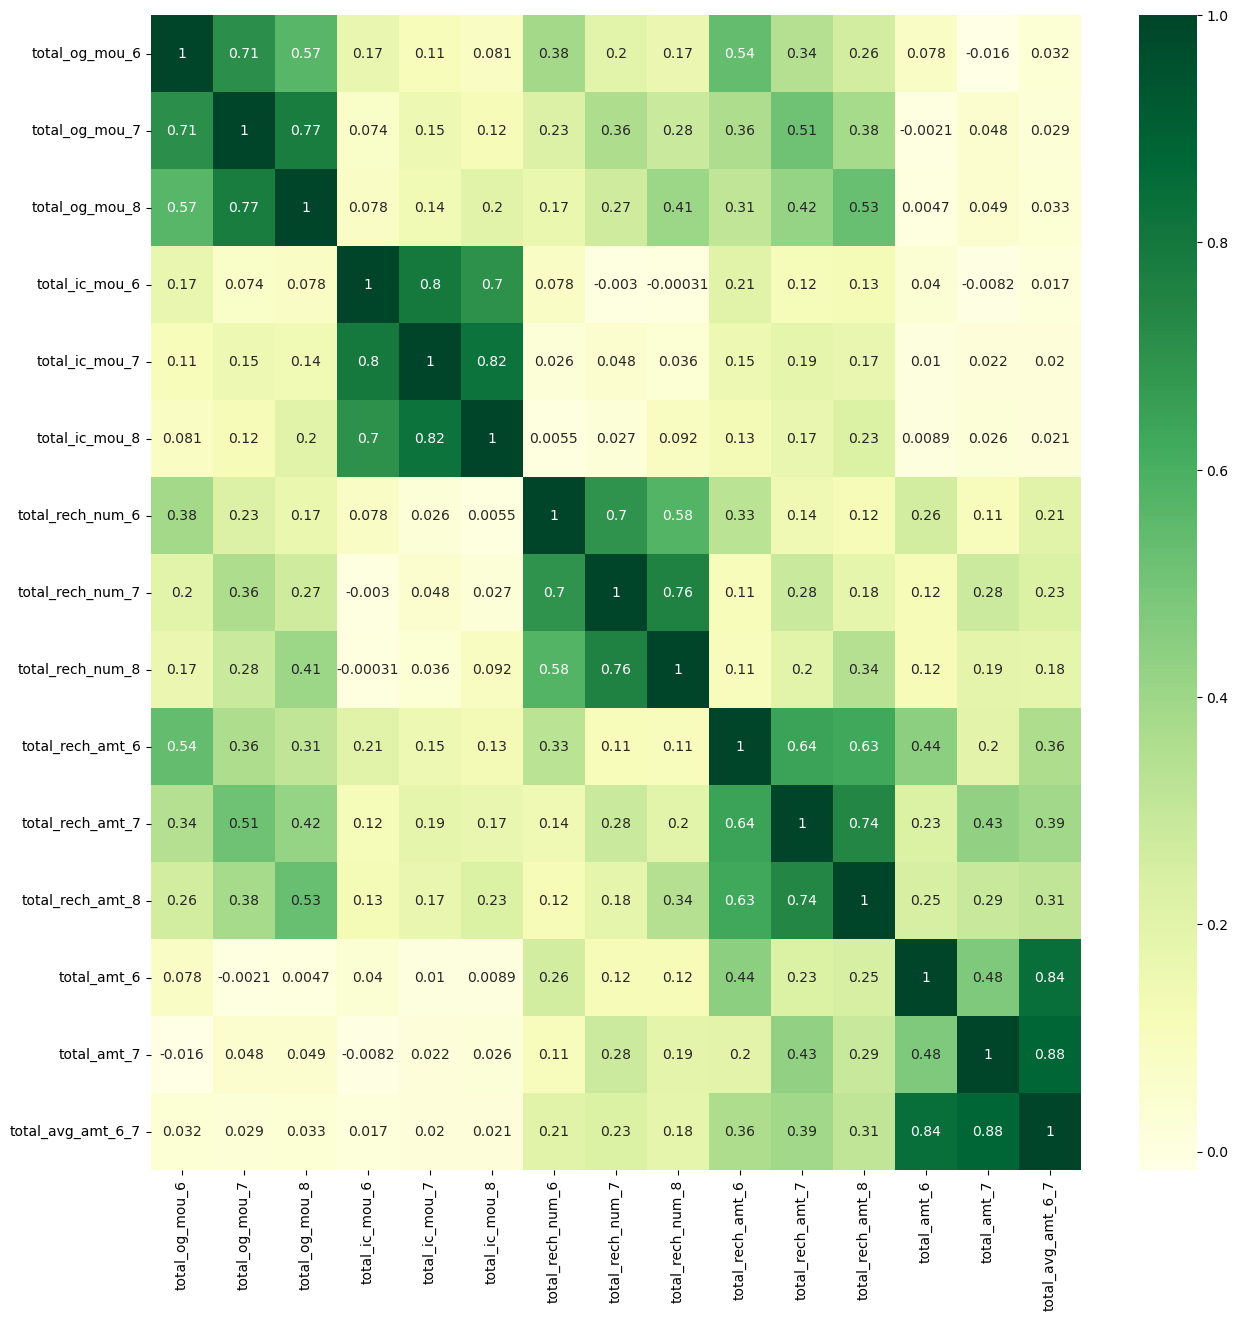

In [83]:
#total_data
plt.figure(figsize=(15,15))
sns.heatmap(total_data.corr(), annot=True, cmap='YlGn')
plt.show()

***Observations:***
- There exists a remarkably high correlation between the incoming (82%) and outgoing minutes (77%) of usage in months 7 and 8.
- Heavy usage suggests that customers are less likely to churn.

In [84]:
# Inspecting shape of the training dataset
final_df.shape

(20998, 149)

In [85]:
final_df.head()

onnet_mou_6  onnet_mou_7  onnet_mou_8  offnet_mou_6  offnet_mou_7  \
0        21.28         4.83         6.13         56.99         38.11   
1        10.43        24.99       194.43        317.11        341.79   
2       859.53       372.71         0.89        293.46        450.11   
3        93.18        38.29        29.86        531.19        507.76   
4         8.58        11.48        12.68        133.16        158.73   

   offnet_mou_8  roam_ic_mou_6  roam_ic_mou_7  roam_ic_mou_8  roam_og_mou_6  \
0          9.63          53.64            0.0            0.0          15.73   
1        197.09           0.00            0.0            0.0           0.00   
2        386.91           0.00            0.0            0.0           0.00   
3        222.03           0.00            0.0            0.0           0.00   
4        182.83           0.00            0.0            0.0           0.00   

   roam_og_mou_7  roam_og_mou_8  loc_og_t2t_mou_6  loc_og_t2t_mou_7  \
0            0.0            0.0             10.16              4.83   
1            0.0            0.0             10.43             24.99   
2            0.0            0.0            859.53            372.71   
3            0.0            0.0             93.18             38.29   
4            0.0            0.0              8.58             11.48   

   loc_og_t2t_mou_8  loc_og_t2m_mou_6  loc_og_t2m_mou_7  loc_og_t2m_mou_8  \
0              6.13             36.74             19.88              4.61   
1            194.43            313.76            330.88            185.88   
2              0.89             79.79            424.63            378.01   
3             29.86            159.29            219.44             99.86   
4             12.68             96.91            149.44            157.23   

   loc_og_t2f_mou_6  loc_og_t2f_mou_7  loc_og_t2f_mou_8  loc_og_t2c_mou_6  \
0             11.99              1.23              5.01               0.0   
1              3.26             10.91              4.94               0.0   
2             11.58             25.43              8.88               0.0   
3              0.00              0.00              0.00               0.0   
4             33.71              9.28             25.59               0.0   

   loc_og_t2c_mou_7  loc_og_t2c_mou_8  loc_og_mou_6  loc_og_mou_7  \
0              9.85              0.00         58.91         25.94   
1              0.00              0.00        327.46        366.79   
2              0.00              0.00        950.91        822.78   
3              0.00              0.36        252.48        257.74   
4              0.00              0.00        139.21        170.21   

   loc_og_mou_8  std_og_t2t_mou_6  std_og_t2t_mou_7  std_og_t2t_mou_8  \
0         15.76               0.0               0.0               0.0   
1        385.26               0.0               0.0               0.0   
2        387.79               0.0               0.0               0.0   
3        129.73               0.0               0.0               0.0   
4        195.51               0.0               0.0               0.0   

   std_og_t2m_mou_6  std_og_t2m_mou_7  std_og_t2m_mou_8  std_og_t2f_mou_6  \
0              4.35              0.00              0.00               0.0   
1              0.00              0.00              0.00               0.0   
2            202.08              0.00              0.00               0.0   
3            371.89            288.31            121.79               0.0   
4              2.53              0.00              0.00               0.0   

   std_og_t2f_mou_7  std_og_t2f_mou_8  std_og_mou_6  std_og_mou_7  \
0               0.0              0.00          4.35          0.00   
1               0.0              6.26          0.00          0.00   
2               0.0              0.00        202.08          0.00   
3               0.0              0.00        371.89        288.31   
4               0.0              0.00          2.53          0.00   

   std_og_

In [86]:
final_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20998 entries, 0 to 20997
Columns: 149 entries, onnet_mou_6 to total_avg_amt_6_7
dtypes: category(7), float64(117), int64(25)
memory usage: 22.9 MB


In [87]:
# Inspecting the shape of the test set
final_unseen_df.shape

(30000, 149)

In [88]:
final_unseen_df.head()

onnet_mou_6  onnet_mou_7  onnet_mou_8  offnet_mou_6  offnet_mou_7  \
0        31.78        20.23        23.11         60.16         32.16   
1        75.51        41.21        19.84        474.34        621.84   
2         7.54         7.86         8.40         16.98         45.81   
3         5.31         2.16         0.00         40.04        205.01   
4       450.93       609.03       700.68         60.94         23.84   

   offnet_mou_8  roam_ic_mou_6  roam_ic_mou_7  roam_ic_mou_8  roam_og_mou_6  \
0         34.83           0.00           0.00           0.00           0.00   
1        394.94           0.00           0.00           0.00           0.00   
2         45.04          22.81         103.38          26.08          24.53   
3         24.01           0.00           0.00           0.00           0.00   
4         74.16           0.00           0.00           0.00           0.00   

   roam_og_mou_7  roam_og_mou_8  loc_og_t2t_mou_6  loc_og_t2t_mou_7  \
0           0.00           0.00             24.88             20.23   
1           0.00           0.00             75.51             41.21   
2          53.68          54.44              0.00              0.00   
3           0.00           0.00              5.31              0.00   
4           0.00           0.00              0.45              0.78   

   loc_og_t2t_mou_8  loc_og_t2m_mou_6  loc_og_t2m_mou_7  loc_og_t2m_mou_8  \
0             21.06             18.13             10.89              8.36   
1             19.84            473.61            598.08            377.26   
2              0.00              0.00              0.00              0.00   
3              0.00              2.94             98.61             20.51   
4             14.56              2.39              2.66             10.94   

   loc_og_t2f_mou_6  loc_og_t2f_mou_7  loc_og_t2f_mou_8  loc_og_t2c_mou_6  \
0              0.00             13.58              0.00               0.0   
1              0.73              0.00              0.00               0.0   
2              0.00              0.00              0.00               0.0   
3              0.00              0.00              2.35               0.0   
4              0.00              0.00              0.00               0.0   

   loc_og_t2c_mou_7  loc_og_t2c_mou_8  loc_og_mou_6  loc_og_mou_7  \
0              0.00              0.03         43.01         44.71   
1              0.00              0.00        549.86        639.29   
2              0.00              0.00          0.00          0.00   
3              6.18              0.00          8.26         98.61   
4              0.00              0.00          2.84          3.44   

   loc_og_mou_8  std_og_t2t_mou_6  std_og_t2t_mou_7  std_og_t2t_mou_8  \
0         29.43              6.90              0.00              2.05   
1        397.11              0.00              0.00              0.00   
2          0.00              0.00              0.00              0.00   
3         22.86              0.00              2.16              0.00   
4         25.51            450.48            608.24            686.11   

   std_og_t2m_mou_6  std_og_t2m_mou_7  std_og_t2m_mou_8  std_og_t2f_mou_6  \
0             42.03              7.68             26.43               0.0   
1              0.00             23.76             17.68               0.0   
2              0.00              0.00              0.00               0.0   
3             37.09             94.36              0.00               0.0   
4             58.54             21.18             63.18               0.0   

   std_og_t2f_mou_7  std_og_t2f_mou_8  std_og_mou_6  std_og_mou_7  \
0               0.0               0.0         48.93          7.68   
1               0.0               0.0          0.00         23.76   
2               0.0               0.0          0.00          0.00   
3               0.0               0.0         37.09         96.53   
4               0.0               0.0        509.03        629.43   

   std_og_

In [89]:
final_unseen_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Columns: 149 entries, onnet_mou_6 to total_avg_amt_6_7
dtypes: category(6), float64(117), int64(26)
memory usage: 32.9 MB


### Dummy Variable Creation (One Hot Encoding) - Training Set

In [90]:
# Creating dummies for categorical columns
dummy_df = pd.get_dummies(final_df[['night_pck_user_8', 'fb_user_8', 'fb_user_7', 'fb_user_6', 'night_pck_user_7', 'night_pck_user_6']], drop_first=True, dtype='int')

In [91]:
final_df = pd.concat([final_df, dummy_df], axis=1)

In [92]:
# drop the category cols
final_df.drop(['night_pck_user_8', 'fb_user_8', 'fb_user_7', 'fb_user_6', 'night_pck_user_7', 'night_pck_user_6'], axis=1, inplace=True)

In [93]:
final_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20998 entries, 0 to 20997
Columns: 155 entries, onnet_mou_6 to night_pck_user_6_1.0
dtypes: category(1), float64(117), int64(37)
memory usage: 24.7 MB


In [94]:
final_df.shape

(20998, 155)

### Dummy Variable Creation (One Hot Encoding) - Test Set

In [95]:
# Creating dummies for categorical columns
dummy_unseen_df = pd.get_dummies(final_unseen_df[['night_pck_user_8', 'fb_user_8', 'fb_user_7', 'fb_user_6', 'night_pck_user_7', 'night_pck_user_6']], drop_first=True, dtype='int')

In [96]:
final_unseen_df = pd.concat([final_unseen_df, dummy_unseen_df], axis=1)

In [97]:
# drop the category cols
final_unseen_df.drop(['night_pck_user_8', 'fb_user_8', 'fb_user_7', 'fb_user_6', 'night_pck_user_7', 'night_pck_user_6'], axis=1, inplace=True)

In [98]:
final_unseen_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Columns: 155 entries, onnet_mou_6 to night_pck_user_6_1.0
dtypes: float64(117), int64(38)
memory usage: 35.5 MB


In [99]:
final_unseen_df.shape

(30000, 155)

### Outlier Treatment

In [100]:
# Checking outliers at 25%, 50%, 75%, 90%, 95% and 99%
final_df.describe(percentiles=[.25, .50, .75, .90, .95, .99])

onnet_mou_6   onnet_mou_7   onnet_mou_8  offnet_mou_6  offnet_mou_7  \
count  20998.000000  20998.000000  20998.000000  20998.000000  20998.000000   
mean     267.178107    272.109430    240.685531    382.267956    383.250630   
std      466.100504    486.527458    465.230834    480.519770    490.938657   
min        0.000000      0.000000      0.000000      0.000000      0.000000   
25%       19.440000     17.940000     13.815000     79.540000     75.790000   
50%       90.235000     87.830000     72.685000    234.680000    228.825000   
75%      292.127500    290.620000    245.405000    495.280000    498.790000   
90%      766.325000    788.211000    672.592000    912.390000    922.828000   
95%     1147.706000   1194.174500   1086.979500   1265.446000   1274.301500   
99%     2164.456000   2239.353000   2153.499100   2338.036700   2394.084300   
max     7376.710000   8157.780000  10752.560000   8362.360000   7043.980000   

       offnet_mou_8  roam_ic_mou_6  roam_ic_mou_7  roam_ic_mou_8  \
count  20998.000000   20998.000000   20998.000000   20998.000000   
mean     344.876032      16.405591      13.039014      12.474249   
std      476.342965      77.640328      77.874472      72.898547   
min        0.000000       0.000000       0.000000       0.000000   
25%       58.000000       0.000000       0.000000       0.000000   
50%      198.600000       0.000000       0.000000       0.000000   
75%      444.155500       0.000000       0.000000       0.000000   
90%      841.962000      28.202000      14.731000      15.916000   
95%     1172.576500      86.367500      56.947500      56.103500   
99%     2178.008900     335.603500     283.862000     276.136000   
max    14007.340000    2613.310000    3813.290000    4169.810000   

       roam_og_mou_6  roam_og_mou_7  roam_og_mou_8  loc_og_t2t_mou_6  \
count   20998.000000   20998.000000   20998.000000      20998.000000   
mean       27.934119      20.690214      19.923240         85.038256   
std       120.392036      96.604433     104.723255        229.249853   
min         0.000000       0.000000       0.000000          0.000000   
25%         0.000000       0.000000       0.000000          5.080000   
50%         0.000000       0.000000       0.000000         25.860000   
75%         0.000000       0.000000       0.000000         81.037500   
90%        52.940000      31.866000      31.440000        186.717000   
95%       154.087500     110.460000      98.946500        318.870500   
99%       546.030900     441.822600     400.673900       1011.725300   
max      3775.110000    2812.040000    5337.040000       6431.330000   

       loc_og_t2t_mou_7  loc_og_t2t_mou_8  loc_og_t2m_mou_6  loc_og_t2m_mou_7  \
count      20998.000000      20998.000000      20998.000000      20998.000000   
mean          86.381224         79.419049        164.867749        163.146258   
std          242.639794        231.911400        248.023716        234.435996   
min            0.000000          0.000000          0.000000          0.000000   
25%            5.190000          3.810000         21.095000         22.330000   
50%           25.840000         22.980000         80.780000         81.785000   
75%           81.877500         75.952500        208.037500        207.112500   
90%          189.975000        178.291000        420.716000        418.840000   
95%          322.768500        298.859500        606.767500        596.846500   
99%         1018.316600        914.494800       1122.801300       1102.060000   
max         7400.660000      10752.560000       4696.830000       4557.140000   

       loc_og_t2m_mou_8  loc_og_t2f_mou_6  loc_og_t2f_mou_7  loc_og_t2f_mou_8  \
count      20998.000000      20998.000000      20998.000000      20998.000000   
mean         153.626906          6.344930          6.421271          6.014550   
std          227.591779         20.192934         20.469962         19.013692   
min            0.000000          0.000000          0.000000          0.000000   

In [101]:
numerical_cols = list(final_df.select_dtypes(exclude='category'))
numerical_cols

['onnet_mou_6',
 'onnet_mou_7',
 'onnet_mou_8',
 'offnet_mou_6',
 'offnet_mou_7',
 'offnet_mou_8',
 'roam_ic_mou_6',
 'roam_ic_mou_7',
 'roam_ic_mou_8',
 'roam_og_mou_6',
 'roam_og_mou_7',
 'roam_og_mou_8',
 'loc_og_t2t_mou_6',
 'loc_og_t2t_mou_7',
 'loc_og_t2t_mou_8',
 'loc_og_t2m_mou_6',
 'loc_og_t2m_mou_7',
 'loc_og_t2m_mou_8',
 'loc_og_t2f_mou_6',
 'loc_og_t2f_mou_7',
 'loc_og_t2f_mou_8',
 'loc_og_t2c_mou_6',
 'loc_og_t2c_mou_7',
 'loc_og_t2c_mou_8',
 'loc_og_mou_6',
 'loc_og_mou_7',
 'loc_og_mou_8',
 'std_og_t2t_mou_6',
 'std_og_t2t_mou_7',
 'std_og_t2t_mou_8',
 'std_og_t2m_mou_6',
 'std_og_t2m_mou_7',
 'std_og_t2m_mou_8',
 'std_og_t2f_mou_6',
 'std_og_t2f_mou_7',
 'std_og_t2f_mou_8',
 'std_og_mou_6',
 'std_og_mou_7',
 'std_og_mou_8',
 'isd_og_mou_6',
 'isd_og_mou_7',
 'isd_og_mou_8',
 'spl_og_mou_6',
 'spl_og_mou_7',
 'spl_og_mou_8',
 'og_others_6',
 'og_others_7',
 'og_others_8',
 'loc_ic_t2t_mou_6',
 'loc_ic_t2t_mou_7',
 'loc_ic_t2t_mou_8',
 'loc_ic_t2m_mou_6',
 'loc_ic_t2m_mou

##### The `outlier_handling` method treats outliers and adjusts skewness in the dataset to improve data robustness and analysis accuracy.

In [102]:
# Handle outliers of numerical columns in the training set
final_df[numerical_cols] = final_df[numerical_cols].apply(outlier_handling)

In [103]:
# Inspecting the numerical columns again in the training set
final_df.describe(percentiles=[.25, .50, .75, .90, .95, .99])

onnet_mou_6   onnet_mou_7   onnet_mou_8  offnet_mou_6  offnet_mou_7  \
count  20998.000000  20998.000000  20998.000000  20998.000000  20998.000000   
mean       4.211145      4.187538      3.998147      5.094089      5.069495   
std        2.016302      2.044539      2.066760      1.674879      1.700994   
min        0.000000      0.000000      0.000000      0.000000      0.000000   
25%        3.017494      2.941276      2.695640      4.388754      4.341074   
50%        4.513439      4.486724      4.299799      5.462475      5.437318   
75%        5.680608      5.675452      5.506977      6.207140      6.214188   
90%        6.642910      6.671034      6.512625      6.817163      6.828526   
95%        7.046391      7.086047      6.992078      7.143970      7.150938   
99%        7.680386      7.714389      7.675314      7.757494      7.781174   
max        8.906219      9.006850      9.282992      9.031616      8.860071   

       offnet_mou_8  roam_ic_mou_6  roam_ic_mou_7  roam_ic_mou_8  \
count  20998.000000   20998.000000   20998.000000   20998.000000   
mean       4.867763       0.714727       0.566272       0.595661   
std        1.803707       1.516127       1.366641       1.367898   
min        0.000000       0.000000       0.000000       0.000000   
25%        4.077537       0.000000       0.000000       0.000000   
50%        5.296315       0.000000       0.000000       0.000000   
75%        6.098424       0.000000       0.000000       0.000000   
90%        6.736922       3.374237       2.755631       2.828260   
95%        7.067811       4.470123       4.059537       4.044865   
99%        7.686625       5.818906       5.652004       5.624508   
max        9.547408       7.868755       8.246510       8.335866   

       roam_og_mou_6  roam_og_mou_7  roam_og_mou_8  loc_og_t2t_mou_6  \
count   20998.000000   20998.000000   20998.000000      20998.000000   
mean        0.835724       0.677072       0.699900          3.073976   
std         1.728675       1.572618       1.561096          1.797018   
min         0.000000       0.000000       0.000000          0.000000   
25%         0.000000       0.000000       0.000000          1.805005   
50%         0.000000       0.000000       0.000000          3.290638   
75%         0.000000       0.000000       0.000000          4.407176   
90%         3.987872       3.492439       3.479392          5.234935   
95%         5.043989       4.713666       4.604635          5.767916   
99%         6.304505       6.093169       5.995640          6.920400   
max         8.236450       7.942021       8.582614          8.769092   

       loc_og_t2t_mou_7  loc_og_t2t_mou_8  loc_og_t2m_mou_6  loc_og_t2m_mou_7  \
count      20998.000000      20998.000000      20998.000000      20998.000000   
mean           3.083290          2.955879          4.052592          4.069222   
std            1.795282          1.832234          1.786655          1.772162   
min            0.000000          0.000000          0.000000          0.000000   
25%            1.822935          1.570697          3.095351          3.149740   
50%            3.289893          3.177220          4.404033          4.416247   
75%            4.417364          4.343188          5.342514          5.338079   
90%            5.252143          5.189010          6.044332          6.039874   
95%            5.780029          5.703314          6.409792          6.393334   
99%            6.926888          6.819465          7.024472          7.005843   
max            8.909460          9.282992          8.454856          8.424670   

       loc_og_t2m_mou_8  loc_og_t2f_mou_6  loc_og_t2f_mou_7  loc_og_t2f_mou_8  \
count      20998.000000      20998.000000      20998.000000      20998.000000   
mean           3.914064          0.931890          0.940274          0.910247   
std            1.871334          1.224449          1.227173          1.208076   
min            0.000000          0.000000          0.000000          0.000000   

In [104]:
# Handle outliers of numerical columns in the test set
final_unseen_df[numerical_cols] = final_unseen_df[numerical_cols].apply(outlier_handling)

In [105]:
# Inspecting the numerical columns again in the test set
final_unseen_df.describe(percentiles=[.25, .50, .75, .90, .95, .99])

onnet_mou_6   onnet_mou_7   onnet_mou_8  offnet_mou_6  offnet_mou_7  \
count  30000.000000  30000.000000  30000.000000  30000.000000  30000.000000   
mean       3.455662      3.399474      3.378268      4.370298      4.322030   
std        1.920246      1.947314      1.946922      1.640813      1.665584   
min        0.000000      0.000000      0.000000      0.000000      0.000000   
25%        2.163093      2.059239      2.033070      3.599775      3.514824   
50%        3.633895      3.548640      3.540089      4.616011      4.552297   
75%        4.848802      4.825109      4.816605      5.502207      5.462984   
90%        5.875610      5.865638      5.844396      6.167812      6.173644   
95%        6.432364      6.435466      6.414786      6.575421      6.609280   
99%        7.232457      7.293730      7.295839      7.326309      7.341630   
max        8.845829      8.910857      8.813556      8.848432      9.176590   

       offnet_mou_8  roam_ic_mou_6  roam_ic_mou_7  roam_ic_mou_8  \
count  30000.000000   30000.000000   30000.000000   30000.000000   
mean       4.293026       0.573719       0.434661       0.448419   
std        1.681240       1.293450       1.124307       1.149469   
min        0.000000       0.000000       0.000000       0.000000   
25%        3.480932       0.000000       0.000000       0.000000   
50%        4.548917       0.000000       0.000000       0.000000   
75%        5.454723       0.000000       0.000000       0.000000   
90%        6.175986       2.811088       2.136767       2.236445   
95%        6.578942       3.724247       3.162581       3.262414   
99%        7.322517       5.383877       5.045232       5.110086   
max        9.514056       9.527002       9.640306       9.480090   

       roam_og_mou_6  roam_og_mou_7  roam_og_mou_8  loc_og_t2t_mou_6  \
count   30000.000000   30000.000000   30000.000000      30000.000000   
mean        0.672716       0.517749       0.513343          2.485723   
std         1.457952       1.289352       1.287077          1.716273   
min         0.000000       0.000000       0.000000          0.000000   
25%         0.000000       0.000000       0.000000          1.032293   
50%         0.000000       0.000000       0.000000          2.593761   
75%         0.000000       0.000000       0.000000          3.778720   
90%         3.360811       2.794289       2.751301          4.640228   
95%         4.270851       3.811783       3.754913          5.164534   
99%         5.612934       5.372013       5.475904          6.310445   
max         7.680841       7.538953       7.959105          8.679232   

       loc_og_t2t_mou_7  loc_og_t2t_mou_8  loc_og_t2m_mou_6  loc_og_t2m_mou_7  \
count      30000.000000      30000.000000      30000.000000      30000.000000   
mean           2.460935          2.457420          3.445514          3.433818   
std            1.714281          1.708465          1.751553          1.746080   
min            0.000000          0.000000          0.000000          0.000000   
25%            0.978326          0.966984          2.416583          2.404690   
50%            2.561868          2.552565          3.760968          3.750445   
75%            3.743368          3.737551          4.739963          4.708719   
90%            4.626344          4.631929          5.457085          5.427550   
95%            5.175081          5.169128          5.848980          5.846940   
99%            6.311273          6.269689          6.607883          6.617005   
max            8.876853          8.813556          8.461837          8.402397   

       loc_og_t2m_mou_8  loc_og_t2f_mou_6  loc_og_t2f_mou_7  loc_og_t2f_mou_8  \
count      30000.000000      30000.000000      30000.000000      30000.000000   
mean           3.418523          0.684468          0.690640          0.682827   
std            1.750432          1.046443          1.051698          1.042433   
min            0.000000          0.000000          0.000000          0.000000   

### Model Building and Evaluation

#### Train-Test Split

Given the availability of the `test.csv` file for testing purposes, this train-test split will exclusively operate on the `train.csv` dataset. It involves allocating 80% of the data for training and 20% for validation.

In [106]:
# Partitioning the dataset into the feature variable 'X' and the response variable 'y'.
X = final_df.drop(['churn_probability'], axis=1)
y = final_df['churn_probability']

In [107]:
X.shape

(20998, 154)

In [108]:
y.shape

(20998,)

In [109]:
X.head()

onnet_mou_6  onnet_mou_7  onnet_mou_8  offnet_mou_6  offnet_mou_7  \
0     3.103689     1.763017     1.964311      4.060271      3.666378   
1     2.436241     3.257712     5.275202      5.762397      5.837118   
2     6.757548     5.923480     0.636577      5.685143      6.111711   
3     4.545208     3.670970     3.429461      6.277001      6.231976   
4     2.259678     2.524127     2.615935      4.899033      5.073485   

   offnet_mou_8  roam_ic_mou_6  roam_ic_mou_7  roam_ic_mou_8  roam_og_mou_6  \
0      2.363680       4.000766            0.0            0.0       2.817204   
1      5.288721       0.000000            0.0            0.0       0.000000   
2      5.960773       0.000000            0.0            0.0       0.000000   
3      5.407306       0.000000            0.0            0.0       0.000000   
4      5.214011       0.000000            0.0            0.0       0.000000   

   roam_og_mou_7  roam_og_mou_8  loc_og_t2t_mou_6  loc_og_t2t_mou_7  \
0            0.0            0.0          2.412336          1.763017   
1            0.0            0.0          2.436241          3.257712   
2            0.0            0.0          6.757548          5.923480   
3            0.0            0.0          4.545208          3.670970   
4            0.0            0.0          2.259678          2.524127   

   loc_og_t2t_mou_8  loc_og_t2m_mou_6  loc_og_t2m_mou_7  loc_og_t2m_mou_8  \
0          1.964311          3.630721          3.038792          1.724551   
1          5.275202          5.751810          5.804773          5.230467   
2          0.636577          4.391853          6.053570          5.937563   
3          3.429461          5.076985          5.395626          4.613733   
4          2.615935          4.584049          5.013564          5.064050   

   loc_og_t2f_mou_6  loc_og_t2f_mou_7  loc_og_t2f_mou_8  loc_og_t2c_mou_6  \
0          2.564180          0.802002          1.793425               0.0   
1          1.449269          2.477378          1.781709               0.0   
2          2.532108          3.274500          2.290513               0.0   
3          0.000000          0.000000          0.000000               0.0   
4          3.547028          2.330200          3.280535               0.0   

   loc_og_t2c_mou_7  loc_og_t2c_mou_8  loc_og_mou_6  loc_og_mou_7  \
0          2.384165          0.000000      4.092843      3.293612   
1          0.000000          0.000000      5.794415      5.907512   
2          0.000000          0.000000      6.858470      6.713904   
3          0.000000          0.307485      5.535285      5.555824   
4          0.000000          0.000000      4.943141      5.142891   

   loc_og_mou_8  std_og_t2t_mou_6  std_og_t2t_mou_7  std_og_t2t_mou_8  \
0      2.818995               0.0               0.0               0.0   
1      5.956511               0.0               0.0               0.0   
2      5.963039               0.0               0.0               0.0   
3      4.873134               0.0               0.0               0.0   
4      5.280713               0.0               0.0               0.0   

   std_og_t2m_mou_6  std_og_t2m_mou_7  std_og_t2m_mou_8  std_og_t2f_mou_6  \
0          1.677097          0.000000          0.000000               0.0   
1          0.000000          0.000000          0.000000               0.0   
2          5.313600          0.000000          0.000000               0.0   
3          5.921283          5.667499          4.810476               0.0   
4          1.261298          0.000000          0.000000               0.0   

   std_og_t2f_mou_7  std_og_t2f_mou_8  std_og_mou_6  std_og_mou_7  \
0               0.0           0.00000      1.677097      0.000000   
1               0.0           1.98238      0.000000      0.000000   
2               0.0           0.00000      5.313600      0.000000   
3               0.0           0.00000      5.921283      5.667499   
4               0.0           0.00000      1.261298      0.000000   

   std_og_

In [110]:
y.head()

0    0
1    0
2    0
3    0
4    0
Name: churn_probability, dtype: category
Categories (2, int64): [0, 1]

In [111]:
# Train test split - 80% training data, 20% validation data
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.20, random_state=100)

In [112]:
# Checking the shape after split
print('X_train Shape:', X_train.shape)
print('y_train Shape:', y_train.shape)
print('X_val Shape:', X_val.shape)
print('y_val Shape:', y_val.shape)

X_train Shape: (16798, 154)
y_train Shape: (16798,)
X_val Shape: (4200, 154)
y_val Shape: (4200,)


In [113]:
y_train.value_counts()

churn_probability
0    15400
1     1398
Name: count, dtype: int64

### Handling Data Imbalance using Synthetic Minority Over-sampling Technique (SMOTE)

In [114]:
smt = SMOTE(random_state=2)
X_train_smote, y_train_smote = smt.fit_resample(X_train, y_train)

In [115]:
X_train_smote.shape

(30800, 154)

In [116]:
y_train_smote.shape

(30800,)

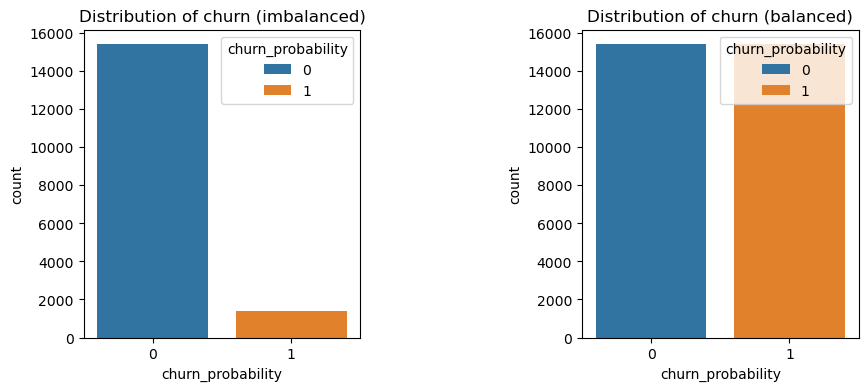

In [117]:
# Checking the distribution on our target variable 'y_train' before and after SMOTE
plt.figure(figsize=(10, 4))
plt.subplot(1,2,1)
plt.title("Distribution of churn (imbalanced)")
sns.countplot(x=y_train, hue=y_train)

plt.subplot(1,2,2)
plt.title("Distribution of churn (balanced)")
sns.countplot(x=y_train_smote, hue=y_train_smote)

plt.subplots_adjust(wspace=0.8)
plt.show()

##### Now the data imbalance issue is sorted.

### Feature Scaling using SandardScaler - Training Set

In [118]:
# Use SandardScaler to scale values
scaler = StandardScaler()

# Fit and transform training set
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train_smote), columns = X_train_smote.columns, index = X_train_smote.index)

# Only Transform validation set
X_val_scaled = pd.DataFrame(scaler.transform(X_val), columns = X_val.columns, index = X_val.index)

In [119]:
X_train_scaled.head()

onnet_mou_6  onnet_mou_7  onnet_mou_8  offnet_mou_6  offnet_mou_7  \
0     0.149095     0.096308     0.612510     -0.131921     -0.127237   
1    -0.011493     0.097476     0.221889     -0.168737     -0.384978   
2     1.347327     1.161152     1.273531     -0.123085     -0.561953   
3     0.575346     0.440481     0.779008      1.168977      1.270920   
4     1.177188     1.567876     1.767948      0.643098     -0.114267   

   offnet_mou_8  roam_ic_mou_6  roam_ic_mou_7  roam_ic_mou_8  roam_og_mou_6  \
0      0.241261       2.442333      -0.530509       2.266093       2.179345   
1      0.112302       0.953740      -0.530509       1.403829       1.516742   
2     -0.429037      -0.527309      -0.530509      -0.665387      -0.547857   
3      1.305695      -0.527309      -0.530509      -0.665387      -0.547857   
4      0.279907      -0.527309      -0.530509      -0.665387      -0.547857   

   roam_og_mou_7  roam_og_mou_8  loc_og_t2t_mou_6  loc_og_t2t_mou_7  \
0      -0.570207       2.091586          0.273358          0.528090   
1      -0.570207       0.612709          0.120880          0.772324   
2      -0.570207      -0.710456          0.854252          0.839267   
3      -0.570207      -0.710456          1.490207          1.300040   
4      -0.570207      -0.710456          0.098173          0.201091   

   loc_og_t2t_mou_8  loc_og_t2m_mou_6  loc_og_t2m_mou_7  loc_og_t2m_mou_8  \
0          0.444381         -0.221222          0.327533          0.122709   
1          0.746190          0.251779          0.058033          0.397475   
2          0.670905         -0.308470         -0.227499         -0.232774   
3          1.566293          1.222987          1.215039          1.283317   
4          0.428037          0.494069          0.168392          0.382760   

   loc_og_t2f_mou_6  loc_og_t2f_mou_7  loc_og_t2f_mou_8  loc_og_t2c_mou_6  \
0         -0.523643          0.030749         -0.702000          2.646044   
1          2.131453          0.957389          0.526302         -0.523327   
2         -0.723977         -0.708078         -0.702000         -0.523327   
3         -0.723977         -0.708078         -0.174374          1.321894   
4         -0.723977         -0.708078         -0.702000          3.168647   

   loc_og_t2c_mou_7  loc_og_t2c_mou_8  loc_og_mou_6  loc_og_mou_7  \
0         -0.431061         -0.561881     -0.095626      0.327006   
1         -0.553555          2.426370      0.265492      0.314291   
2         -0.553555         -0.561881      0.213056      0.235414   
3          0.009698          0.364614      1.197908      1.129762   
4          2.238548          4.552165      0.335443      0.118395   

   loc_og_mou_8  std_og_t2t_mou_6  std_og_t2t_mou_7  std_og_t2t_mou_8  \
0      0.199787         -0.004909          0.369364          0.763584   
1      0.473698          0.278301         -0.011331          0.247915   
2      0.165723          1.564210          1.436982          1.666454   
3      1.248243         -0.119937         -0.565591         -0.146562   
4      0.351985          1.449056          1.791442          2.110142   

   std_og_t2m_mou_6  std_og_t2m_mou_7  std_og_t2m_mou_8  std_og_t2f_mou_6  \
0          0.050382          0.250152          0.324024         -0.357822   
1         -0.288979          0.091731          0.239823         -0.357822   
2          0.545872          0.100389          0.227695         -0.357822   
3          1.345162          1.469213          1.628964         -0.357822   
4          1.039956          0.007980         -0.372941         -0.357822   

   std_og_t2f_mou_7  std_og_t2f_mou_8  std_og_mou_6  std_og_mou_7  \
0          -0.35426         -0.361356     -0.081116      0.188767   
1          -0.35426          3.410393     -0.071046     -0.045679   
2          -0.35426         -0.361356      1.099366      0.951415   
3          -0.35426         -0.361356      0.953129      1.066917   
4          -0.35426         -0.361356      1.091245      1.276429   

   std_og_

### Feature Scaling using SandardScaler - Unseen Test Set

In [120]:
final_unseen_df.head()

onnet_mou_6  onnet_mou_7  onnet_mou_8  offnet_mou_6  offnet_mou_7  \
0     3.489819     3.055415     3.182627      4.113493      3.501344   
1     4.337421     3.742657     3.036874      6.164030      6.434290   
2     2.144761     2.181547     2.240710      2.889260      3.846097   
3     1.842136     1.150572     0.000000      3.714547      5.327925   
4     6.113527     6.413508     6.553477      4.126166      3.212455   

   offnet_mou_8  roam_ic_mou_6  roam_ic_mou_7  roam_ic_mou_8  roam_og_mou_6  \
0      3.578786       0.000000       0.000000       0.000000       0.000000   
1      5.981263       0.000000       0.000000       0.000000       0.000000   
2      3.829511       3.170106       4.648038       3.298795       3.239854   
3      3.219276       0.000000       0.000000       0.000000       0.000000   
4      4.319619       0.000000       0.000000       0.000000       0.000000   

   roam_og_mou_7  roam_og_mou_8  loc_og_t2t_mou_6  loc_og_t2t_mou_7  \
0       0.000000       0.000000          3.253470          3.055415   
1       0.000000       0.000000          4.337421          3.742657   
2       4.001498       4.015301          0.000000          0.000000   
3       0.000000       0.000000          1.842136          0.000000   
4       0.000000       0.000000          0.371564          0.576613   

   loc_og_t2t_mou_8  loc_og_t2m_mou_6  loc_og_t2m_mou_7  loc_og_t2m_mou_8  \
0          3.093766          2.951258          2.475698          2.236445   
1          3.036874          6.162493          6.395395          5.935582   
2          0.000000          0.000000          0.000000          0.000000   
3          0.000000          1.371181          4.601263          3.068518   
4          2.744704          1.220830          1.297463          2.479894   

   loc_og_t2f_mou_6  loc_og_t2f_mou_7  loc_og_t2f_mou_8  loc_og_t2c_mou_6  \
0          0.000000          2.679651           0.00000               0.0   
1          0.548121          0.000000           0.00000               0.0   
2          0.000000          0.000000           0.00000               0.0   
3          0.000000          0.000000           1.20896               0.0   
4          0.000000          0.000000           0.00000               0.0   

   loc_og_t2c_mou_7  loc_og_t2c_mou_8  loc_og_mou_6  loc_og_mou_7  \
0          0.000000          0.029559      3.784417      3.822317   
1          0.000000          0.000000      6.311481      6.461921   
2          0.000000          0.000000      0.000000      0.000000   
3          1.971299          0.000000      2.225704      4.601263   
4          0.000000          0.000000      1.345472      1.490654   

   loc_og_mou_8  std_og_t2t_mou_6  std_og_t2t_mou_7  std_og_t2t_mou_8  \
0      3.415429          2.066863          0.000000          1.115142   
1      5.986728          0.000000          0.000000          0.000000   
2      0.000000          0.000000          0.000000          0.000000   
3      3.172203          0.000000          1.150572          0.000000   
4      3.277522          6.112531          6.412212          6.532494   

   std_og_t2m_mou_6  std_og_t2m_mou_7  std_og_t2m_mou_8  std_og_t2f_mou_6  \
0          3.761898          2.161022          3.311637               0.0   
1          0.000000          3.209229          2.927453               0.0   
2          0.000000          0.000000          0.000000               0.0   
3          3.639952          4.557659          0.000000               0.0   
4          4.086648          3.099191          4.161692               0.0   

   std_og_t2f_mou_7  std_og_t2f_mou_8  std_og_mou_6  std_og_mou_7  \
0               0.0               0.0      3.910622      2.161022   
1               0.0               0.0      0.000000      3.209229   
2               0.0               0.0      0.000000      0.000000   
3               0.0               0.0      3.639952      4.580160   
4               0.0               0.0      6.234470      6.446402   

   std_og_

In [121]:
final_unseen_df.set_index('id', inplace=True)

### Model 1. Logistic Regression with Recursive Feature Elimination (RFE)

In [122]:
%%time
# Select top 20 features using RFE
logreg = LogisticRegression(max_iter=1000, tol=0.001, solver='sag')
rfe = RFE(logreg, n_features_to_select=20)
rfe = rfe.fit(X_train_scaled, y_train_smote)

CPU times: user 3min 28s, sys: 2.27 s, total: 3min 30s
Wall time: 3min 31s


In [123]:
list(zip(X_train_scaled.columns, rfe.support_, rfe.ranking_))

[('onnet_mou_6', False, 59),
 ('onnet_mou_7', False, 26),
 ('onnet_mou_8', False, 25),
 ('offnet_mou_6', False, 92),
 ('offnet_mou_7', False, 16),
 ('offnet_mou_8', False, 13),
 ('roam_ic_mou_6', False, 69),
 ('roam_ic_mou_7', False, 34),
 ('roam_ic_mou_8', True, 1),
 ('roam_og_mou_6', False, 68),
 ('roam_og_mou_7', False, 28),
 ('roam_og_mou_8', True, 1),
 ('loc_og_t2t_mou_6', False, 94),
 ('loc_og_t2t_mou_7', False, 66),
 ('loc_og_t2t_mou_8', False, 74),
 ('loc_og_t2m_mou_6', False, 22),
 ('loc_og_t2m_mou_7', False, 36),
 ('loc_og_t2m_mou_8', False, 23),
 ('loc_og_t2f_mou_6', False, 119),
 ('loc_og_t2f_mou_7', False, 38),
 ('loc_og_t2f_mou_8', False, 37),
 ('loc_og_t2c_mou_6', False, 79),
 ('loc_og_t2c_mou_7', False, 129),
 ('loc_og_t2c_mou_8', False, 109),
 ('loc_og_mou_6', False, 21),
 ('loc_og_mou_7', False, 15),
 ('loc_og_mou_8', False, 14),
 ('std_og_t2t_mou_6', False, 32),
 ('std_og_t2t_mou_7', False, 27),
 ('std_og_t2t_mou_8', False, 24),
 ('std_og_t2m_mou_6', False, 33),
 ('s

In [124]:
# Selected features using RFE
selected_features = X_train_scaled.columns[rfe.support_]
selected_features

Index(['roam_ic_mou_8', 'roam_og_mou_8', 'loc_ic_t2t_mou_7',
       'loc_ic_t2t_mou_8', 'loc_ic_t2m_mou_7', 'loc_ic_t2m_mou_8',
       'loc_ic_mou_7', 'loc_ic_mou_8', 'spl_ic_mou_8', 'total_ic_mou_8',
       'total_rech_num_7', 'total_rech_num_8', 'total_rech_amt_6',
       'total_rech_amt_8', 'max_rech_amt_6', 'max_rech_amt_8',
       'last_day_rch_amt_8', 'max_rech_data_8', 'count_rech_2g_8',
       'night_pck_user_8_0.0'],
      dtype='object')

In [125]:
X_train_scaled_final = X_train_scaled[selected_features]
logreg.fit(X_train_scaled_final, y_train_smote)

LogisticRegression(max_iter=1000, solver='sag', tol=0.001)

In [126]:
y_train_smote_pred = logreg.predict(X_train_scaled_final)

In [127]:
# Calculate metrics on the training set
calculate_classification_metrics(y_train_smote, y_train_smote_pred)

Confusion Matrix

[[13532  1868]
 [ 2541 12859]]


Metric   Value
0             Accuracy  0.8569
1          Sensitivity  0.8350
2          Specificity  0.8787
3            Precision  0.8732
4  False Positive Rate  0.1213
5   True Positive Rate  0.8350

In [128]:
# Retain only the selected feature from the final model
X_val_scaled_final = X_val_scaled[selected_features]
X_val_scaled_final.head()

roam_ic_mou_8  roam_og_mou_8  loc_ic_t2t_mou_7  loc_ic_t2t_mou_8  \
3837       -0.665387      -0.710456         -0.630123         -0.290162   
11055      -0.665387      -0.710456         -1.797890         -1.503512   
12221      -0.665387      -0.710456         -0.936447          0.500098   
17179       0.507003       0.310656         -1.797890         -1.503512   
16047      -0.665387      -0.710456          1.009885          1.293738   

       loc_ic_t2m_mou_7  loc_ic_t2m_mou_8  loc_ic_mou_7  loc_ic_mou_8  \
3837          -1.557467         -0.780543     -1.260504     -0.619065   
11055         -2.375165         -1.877598     -2.594405     -1.984776   
12221         -1.291167         -0.008028     -1.288234      0.116256   
17179         -2.375165         -1.877598     -2.594405     -1.984776   
16047          0.136624          0.558736      0.498657      0.815104   

       spl_ic_mou_8  total_ic_mou_8  total_rech_num_7  total_rech_num_8  \
3837      -0.266206       -0.300154         -1.082799         -0.101475   
11055      2.474225       -1.317514         -1.434322         -0.619858   
12221      6.933130        0.329095          0.159277          1.437791   
17179     -0.266206       -1.395256          0.159277         -0.101475   
16047     -0.266206        0.859190         -1.887514         -0.987657   

       total_rech_amt_6  total_rech_amt_8  max_rech_amt_6  max_rech_amt_8  \
3837           0.204074          0.547510        0.794832        0.902878   
11055          0.035264          0.561889        0.794832        0.902878   
12221         -5.086412          0.669800       -4.510459        0.156583   
17179          0.347429         -0.539241        0.004934       -0.256881   
16047          0.431105         -1.678770        1.078205       -1.675565   

       last_day_rch_amt_8  max_rech_data_8  count_rech_2g_8  \
3837            -1.039975         1.790895        -0.595224   
11055           -1.039975         1.790895        -0.595224   
12221            0.724532        -0.735593        -0.595224   
17179           -1.039975        -0.735593        -0.595224   
16047           -1.039975        -0.735593        -0.595224   

       night_pck_user_8_0.0  
3837               1.363391  
11055              1.363391  
12221             -0.759323  
17179             -0.759323  
16047             -0.759323

In [129]:
# Get the predicted values from the linear model
y_val_pred = logreg.predict(X_val_scaled_final)

In [130]:
confusion = confusion_matrix(y_true=y_val, y_pred=y_val_pred)
print(confusion)

[[3379  484]
 [  76  261]]


In [131]:
# Calculate metrics
metrics_df = calculate_classification_metrics(y_true=y_val, y_pred=y_val_pred)
metrics_df

Confusion Matrix

[[3379  484]
 [  76  261]]


Metric   Value
0             Accuracy  0.8667
1          Sensitivity  0.7745
2          Specificity  0.8747
3            Precision  0.3503
4  False Positive Rate  0.1253
5   True Positive Rate  0.7745

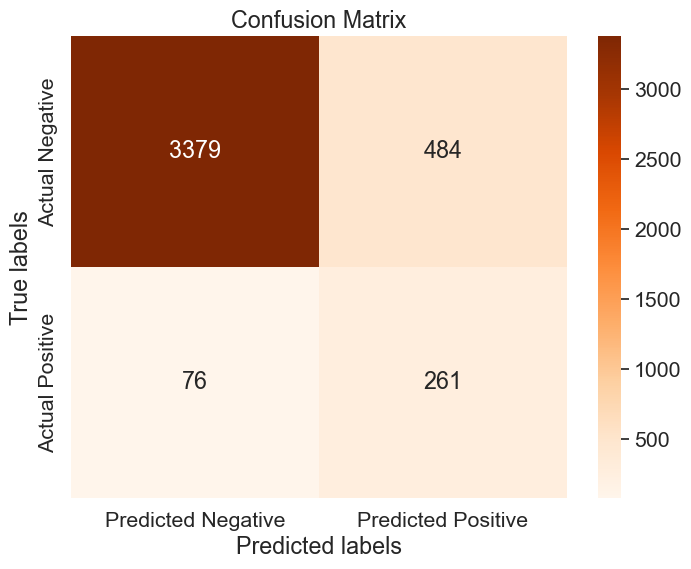

In [132]:
# Define labels for the confusion matrix
labels = ['True Negative', 'False Positive', 'False Negative', 'True Positive']

# Reshape the confusion matrix into a 2x2 array
cm_array = np.array(confusion).reshape(2,2)

# Create the heatmap
plt.figure(figsize=(8,6))
sns.set(font_scale=1.4)
sns.heatmap(cm_array, annot=True, cmap='Oranges', fmt='g', xticklabels=['Predicted Negative', 'Predicted Positive'], yticklabels=['Actual Negative', 'Actual Positive'])
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

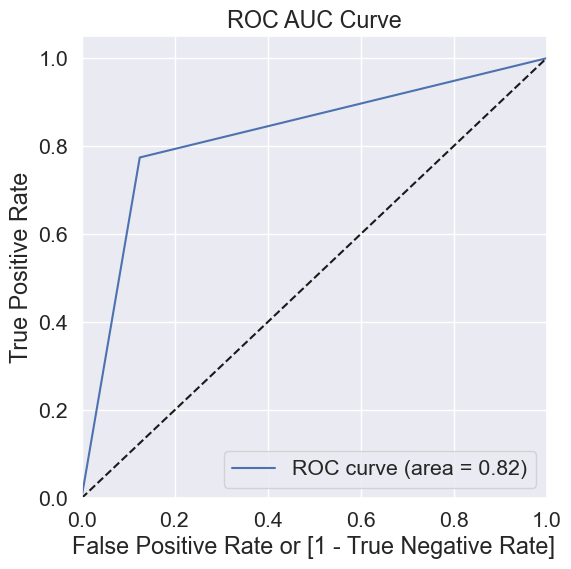

In [133]:
# ROC curve
fpr, tpr, thresholds = draw_roc(y_val, y_val_pred)

In [134]:
# ROC AUC Score
"{:2.2f}".format(roc_auc_score(y_val, y_val_pred))

'0.82'

### Model 2. Logistic Regression with PCA and Hyperparameter Tuning

In [135]:
pca = PCA()

In [136]:
pca_components = pca.fit_transform(X_train)
pca_components

array([[ 4.89135055e-01,  2.83721156e+00,  3.62021401e+00, ...,
         7.89804810e-15,  1.66519300e-14, -4.08719261e-14],
       [ 6.47598780e+00, -4.59803150e+00, -1.14579551e+00, ...,
        -2.07638250e-14,  8.90347948e-15,  1.55894464e-15],
       [ 1.19215807e+01, -4.15662423e+00,  2.45699559e+00, ...,
         2.53062975e-14,  1.34418401e-14,  1.83659278e-14],
       ...,
       [-3.92522050e+00,  3.86954317e+00, -2.86308492e-01, ...,
         3.35950692e-14,  3.97121907e-14, -7.31723489e-15],
       [-1.23247013e+01, -8.91514399e-01, -1.74474951e+00, ...,
         4.38983202e-14,  3.68342839e-14, -7.87424625e-15],
       [-2.52714922e+01, -4.94115360e+00,  6.79133427e+00, ...,
        -1.45936608e-13, -7.28870624e-14, -6.98056870e-14]])

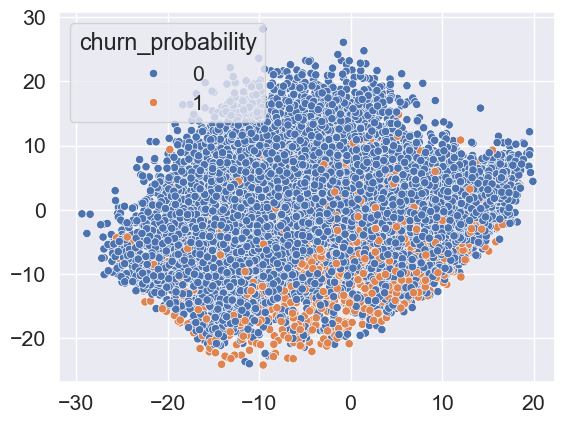

In [137]:
sns.scatterplot(x=pca_components[:,0], y=pca_components[:,1], hue=y_train)
plt.show()

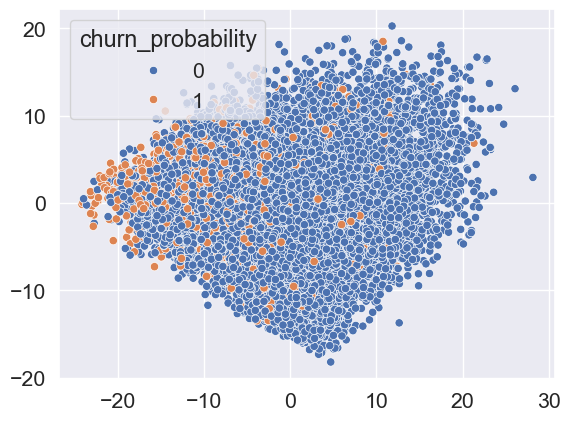

In [138]:
sns.scatterplot(x=pca_components[:,1], y=pca_components[:,2], hue=y_train)
plt.show()

##### As we can see, there is a clear class imbalance and we have addressed this below using SMOTE

In [139]:
X = high_val_train.copy().drop(['churn_probability'], axis=1)
y = high_val_train.copy()['churn_probability']

In [140]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=100)

In [141]:
imputer = SimpleImputer(strategy='constant', fill_value=0)
scaler = StandardScaler()
pca = PCA(n_components=20)
smote = SMOTE(random_state=2)
lr = LogisticRegression(max_iter=1000, tol=0.001, random_state=42)

In [142]:
pipe = make_pipeline(
    imputer,
    smote,
    scaler,
    pca,
    lr
)

In [143]:
# Define hyperparameters grid for GridSearchCV
param_grid = {
    'logisticregression__C': [0.001, 0.01, 0.1, 1, 10, 100],
    'logisticregression__solver': ['liblinear', 'saga'],
}

In [144]:
# Instantiate GridSearchCV
lr_grid_search = GridSearchCV(pipe, param_grid, cv=5, scoring='accuracy', n_jobs=-1, verbose=1)

In [145]:
# Fit the model using GridSearchCV
lr_grid_search.fit(X_train, y_train)

# Get the best parameters and estimator
lr_best_params = lr_grid_search.best_params_
lr_best_estimator = lr_grid_search.best_estimator_

Fitting 5 folds for each of 12 candidates, totalling 60 fits


In [146]:
# Predict values on the training set
y_train_pred = lr_grid_search.predict(X_train)

In [147]:
# Predict values on the validation set
y_val_pred = lr_grid_search.predict(X_val)

In [148]:
# Metrics of the training set
calculate_classification_metrics(y_train, y_train_pred)

Confusion Matrix

[[12478  2922]
 [  277  1121]]


Metric   Value
0             Accuracy  0.8096
1          Sensitivity  0.8019
2          Specificity  0.8103
3            Precision  0.2773
4  False Positive Rate  0.1897
5   True Positive Rate  0.8019

In [149]:
# Metrics of the validation set
calculate_classification_metrics(y_val, y_val_pred)

Confusion Matrix

[[3141  722]
 [  77  260]]


Metric   Value
0             Accuracy  0.8098
1          Sensitivity  0.7715
2          Specificity  0.8131
3            Precision  0.2648
4  False Positive Rate  0.1869
5   True Positive Rate  0.7715

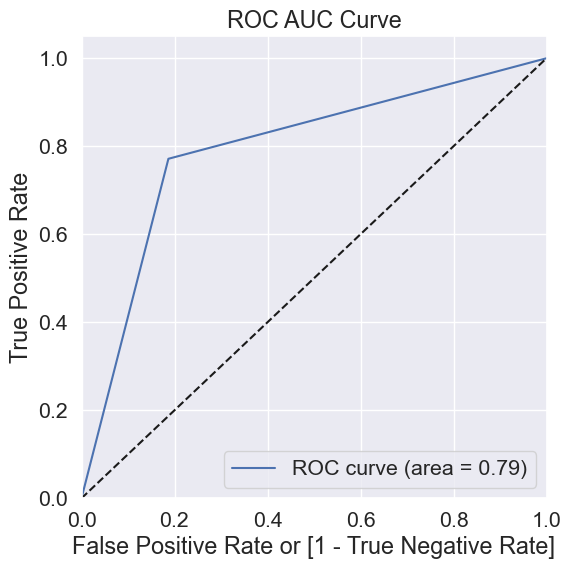

In [150]:
# ROC curve
fpr, tpr, thresholds = draw_roc(y_val, y_val_pred)

### Model 3. Decision Tree with PCA and GridSearchCV

In [151]:
dt = DecisionTreeClassifier(random_state=42)

In [152]:
imputer = SimpleImputer(strategy='constant', fill_value=0)
scaler = StandardScaler()
pca = PCA(n_components=25)
smote = SMOTE(random_state=2)

In [153]:
# Create a pipeline
pipe = make_pipeline(
    imputer,
    smote,
    scaler,
    pca,
    dt
)

In [154]:
# Create the parameter grid based on the results of random search 
params = {
    'decisiontreeclassifier__max_depth': [2, 3, 5, 10, 20],
    'decisiontreeclassifier__min_samples_leaf': [5, 10, 20, 50, 100],
}

In [155]:
# Instantiate the grid search model
grid_search = GridSearchCV(estimator=pipe, 
                           param_grid=params, 
                           cv=5, n_jobs=-1, verbose=1, scoring = "accuracy")

In [156]:
# Fit the GridSearchCV
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 25 candidates, totalling 125 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('simpleimputer',
                                        SimpleImputer(fill_value=0,
                                                      strategy='constant')),
                                       ('smote', SMOTE(random_state=2)),
                                       ('standardscaler', StandardScaler()),
                                       ('pca', PCA(n_components=25)),
                                       ('decisiontreeclassifier',
                                        DecisionTreeClassifier(random_state=42))]),
             n_jobs=-1,
             param_grid={'decisiontreeclassifier__max_depth': [2, 3, 5, 10, 20],
                         'decisiontreeclassifier__min_samples_leaf': [5, 10, 20,
                                                                      50,
                                                                      100]},
             scoring='accuracy', verbose=1)

In [157]:
# Get the best parameters and the best score
best_params = grid_search.best_params_
best_score = grid_search.best_score_

# Predict on train set using the best model
y_train_pred = grid_search.predict(X_train)

# Predict on validation set using the best model
y_val_pred = grid_search.predict(X_val)

In [158]:
# Metrics on the train set
calculate_classification_metrics(y_train, y_train_pred)

Confusion Matrix

[[14670   730]
 [   71  1327]]


Metric   Value
0             Accuracy  0.9523
1          Sensitivity  0.9492
2          Specificity  0.9526
3            Precision  0.6451
4  False Positive Rate  0.0474
5   True Positive Rate  0.9492

In [159]:
# Metrics on the validation set
calculate_classification_metrics(y_val, y_val_pred)

Confusion Matrix

[[3297  566]
 [ 154  183]]


Metric   Value
0             Accuracy  0.8286
1          Sensitivity  0.5430
2          Specificity  0.8535
3            Precision  0.2443
4  False Positive Rate  0.1465
5   True Positive Rate  0.5430

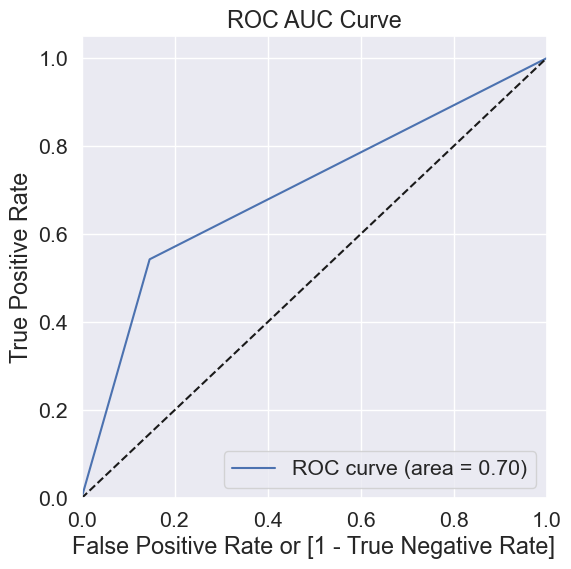

In [160]:
# ROC curve
fpr, tpr, thresholds = draw_roc(y_val, y_val_pred)

### Model 4. Random Forest Classifier with PCA and Hyperparameter Tuning

In [161]:
rf = RandomForestClassifier(random_state=42)

In [162]:
# Create a pipeline
pipe = make_pipeline(
    imputer,
    smote,
    scaler,
    pca,
    rf
)

In [163]:
# Define the hyperparameters grid for Random Forest
param_grid = {
    'randomforestclassifier__n_estimators': [100],  
    'randomforestclassifier__max_depth': [5, 10],       
    'randomforestclassifier__min_samples_split': [2, 5, 10],
}

In [164]:
grid_search = GridSearchCV(pipe, param_grid, cv=5, scoring='accuracy', n_jobs=-1, verbose=1)

In [165]:
%%time
# Fit the grid search to the training data
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 6 candidates, totalling 30 fits
CPU times: user 9.67 s, sys: 2.25 s, total: 11.9 s
Wall time: 33.3 s


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('simpleimputer',
                                        SimpleImputer(fill_value=0,
                                                      strategy='constant')),
                                       ('smote', SMOTE(random_state=2)),
                                       ('standardscaler', StandardScaler()),
                                       ('pca', PCA(n_components=25)),
                                       ('randomforestclassifier',
                                        RandomForestClassifier(random_state=42))]),
             n_jobs=-1,
             param_grid={'randomforestclassifier__max_depth': [5, 10],
                         'randomforestclassifier__min_samples_split': [2, 5,
                                                                       10],
                         'randomforestclassifier__n_estimators': [100]},
             scoring='accuracy', verbose=1)

In [166]:
# Get the best parameters
best_params = grid_search.best_params_
print("Best Parameters:", best_params)

# Get the best model
best_model = grid_search.best_estimator_

# Predict on train set using the best model
y_train_pred = best_model.predict(X_train)

# Predict on train set using the validation model
y_test_pred = best_model.predict(X_val)

Best Parameters: {'randomforestclassifier__max_depth': 10, 'randomforestclassifier__min_samples_split': 2, 'randomforestclassifier__n_estimators': 100}


In [167]:
# Metrics on the train set
calculate_classification_metrics(y_train, y_train_pred)

Confusion Matrix

[[13955  1445]
 [   80  1318]]


Metric   Value
0             Accuracy  0.9092
1          Sensitivity  0.9428
2          Specificity  0.9062
3            Precision  0.4770
4  False Positive Rate  0.0938
5   True Positive Rate  0.9428

In [168]:
# Metrics on the validation set
calculate_classification_metrics(y_val, y_val_pred)

Confusion Matrix

[[3297  566]
 [ 154  183]]


Metric   Value
0             Accuracy  0.8286
1          Sensitivity  0.5430
2          Specificity  0.8535
3            Precision  0.2443
4  False Positive Rate  0.1465
5   True Positive Rate  0.5430

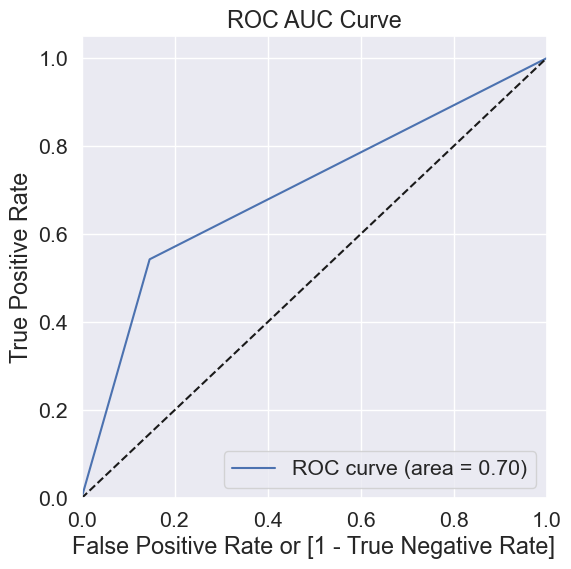

In [169]:
# ROC curve
fpr, tpr, thresholds = draw_roc(y_val, y_val_pred)

### Model 5. AdaBoost Classifier

In [170]:
# Create a pipeline
pipe = make_pipeline(
    imputer,
    smote,
    scaler,
    pca,
    AdaBoostClassifier(n_estimators=200, random_state=42)
)

In [171]:
# Build the model
adaboost_model = pipe.fit(X_train, y_train)

In [172]:
# Predict on train set using the best model
y_train_pred = adaboost_model.predict(X_train)

# Predict on train set using the validation model
y_test_pred = adaboost_model.predict(X_val)

In [173]:
# Metrics on the train set
calculate_classification_metrics(y_train, y_train_pred)

Confusion Matrix

[[12959  2441]
 [  285  1113]]


Metric   Value
0             Accuracy  0.8377
1          Sensitivity  0.7961
2          Specificity  0.8415
3            Precision  0.3132
4  False Positive Rate  0.1585
5   True Positive Rate  0.7961

In [174]:
# Metrics on the validation set
calculate_classification_metrics(y_val, y_val_pred)

Confusion Matrix

[[3297  566]
 [ 154  183]]


Metric   Value
0             Accuracy  0.8286
1          Sensitivity  0.5430
2          Specificity  0.8535
3            Precision  0.2443
4  False Positive Rate  0.1465
5   True Positive Rate  0.5430

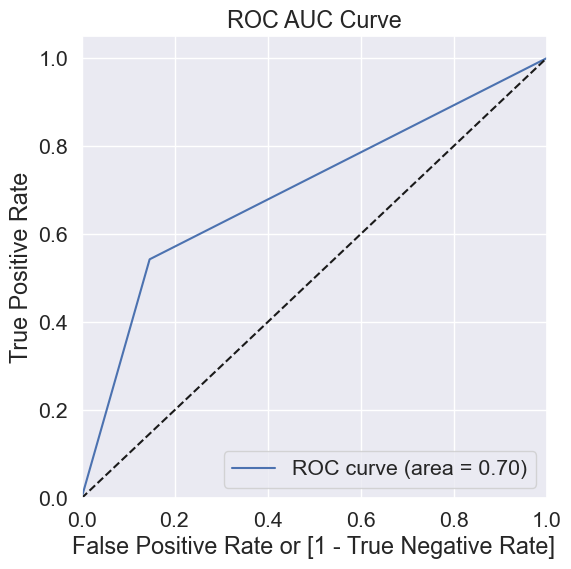

In [175]:
# ROC curve
fpr, tpr, thresholds = draw_roc(y_val, y_val_pred)

### Model 6. XGBoost Classifier

In [176]:
# Create a pipeline
pipe = make_pipeline(
    imputer,
    smote,
    scaler,
    pca,
    XGBClassifier(random_state=42)
)

In [177]:
# Define hyperparameters for grid search
param_grid = {
    'xgbclassifier__n_estimators': [100, 200, 300],  
    'xgbclassifier__max_depth': [3, 5, 7],
    'xgbclassifier__learning_rate': [0.01, 0.1, 0.3]
}

In [178]:
# Instantiate GridSearchCV
grid_search = GridSearchCV(pipe, param_grid, cv=5, scoring='accuracy', n_jobs=-1, verbose=1)

In [179]:
%%time
# Train the model
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 27 candidates, totalling 135 fits
CPU times: user 3.55 s, sys: 3.02 s, total: 6.57 s
Wall time: 19.3 s


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('simpleimputer',
                                        SimpleImputer(fill_value=0,
                                                      strategy='constant')),
                                       ('smote', SMOTE(random_state=2)),
                                       ('standardscaler', StandardScaler()),
                                       ('pca', PCA(n_components=25)),
                                       ('xgbclassifier',
                                        XGBClassifier(base_score=None,
                                                      booster=None,
                                                      callbacks=None,
                                                      colsample_bylevel=None,
                                                      colsample_bynode=None,
                                                      colsample_bytree=None,
                                                      d...
                                                      max_leaves=None,
                                                      min_child_weight=None,
                                                      missing=nan,
                                                      monotone_constraints=None,
                                                      multi_strategy=None,
                                                      n_estimators=None,
                                                      n_jobs=None,
                                                      num_parallel_tree=None,
                                                      random_state=42, ...))]),
             n_jobs=-1,
             param_grid={'xgbclassifier__learning_rate': [0.01, 0.1, 0.3],
                         'xgbclassifier__max_depth': [3, 5, 7],
                         'xgbclassifier__n_estimators': [100, 200, 300]},
             scoring='accuracy', verbose=1)

In [180]:
# Get the best parameters
best_params = grid_search.best_params_
print("Best Parameters:", best_params)

# Get the best model
best_model = grid_search.best_estimator_

# Predict on train set using the best model
y_train_pred = best_model.predict(X_train)

# Predict on train set using the validation model
y_test_pred = best_model.predict(X_val)

Best Parameters: {'xgbclassifier__learning_rate': 0.3, 'xgbclassifier__max_depth': 7, 'xgbclassifier__n_estimators': 300}


In [181]:
# Metrics on the train set
calculate_classification_metrics(y_train, y_train_pred)

Confusion Matrix

[[15400     0]
 [    0  1398]]


Metric  Value
0             Accuracy    1.0
1          Sensitivity    1.0
2          Specificity    1.0
3            Precision    1.0
4  False Positive Rate    0.0
5   True Positive Rate    1.0

In [182]:
# Metrics on the validation set
calculate_classification_metrics(y_val, y_val_pred)

Confusion Matrix

[[3297  566]
 [ 154  183]]


Metric   Value
0             Accuracy  0.8286
1          Sensitivity  0.5430
2          Specificity  0.8535
3            Precision  0.2443
4  False Positive Rate  0.1465
5   True Positive Rate  0.5430

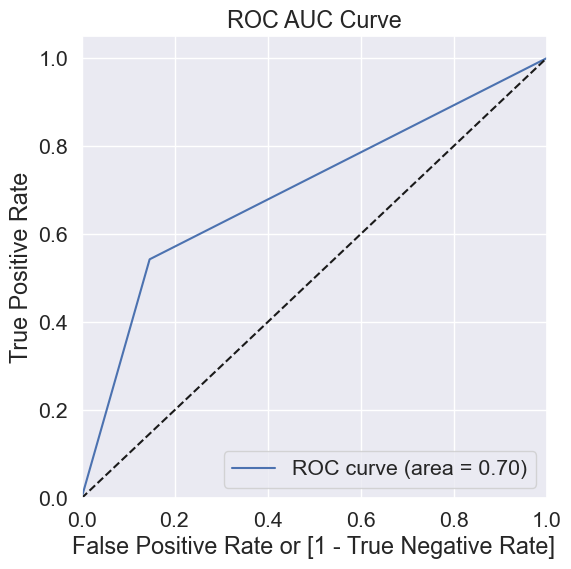

In [183]:
# ROC curve
fpr, tpr, thresholds = draw_roc(y_val, y_val_pred)

### Create `submission.csv` file for final submission on Kaggle

For our Kaggle submission, we've opted for logistic regression with Recursive Feature Elimination (RFE) due to the platform's evaluation metric being accuracy. This model consistently achieves approximately 85% accuracy on both the training and test sets. Notably, it also demonstrates a commendable accuracy of 93.8% on previously unseen data.

In [184]:
submission_data = final_unseen_df[selected_features]
submission_data.shape

(30000, 20)

In [185]:
final_unseen_df['churn_probability'] = logreg.predict(submission_data)
output = final_unseen_df[['churn_probability']]
output.head()

churn_probability
id                      
69999                  0
70000                  0
70001                  1
70002                  0
70003                  0

In [186]:
output.to_csv('submission.csv',index=True)